# Facebook Prophet Time Series 
###### Predicting the number of individuals infected with Dengue Fever in two tropical cities, San Juan, Puerto Rico and Iquitos, Peru


In this notebook we use [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) to build a time series model for each city.  The data comes from a competition hosted by [DrivenData](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).  The data set is composed of of weekly measurements of the number of infected individuals in each tropical city (1990-2008 San Juan, 200-2010 Iquitos), along with meteorological data.  The goal is to predict the number of cases per week on a data set where only the number of cases is unknown.   

In [1]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt


In [2]:
target = pd.read_csv('DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv')
train = pd.read_csv('DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv')

In [3]:
target.tail()

city  year  weekofyear  total_cases
1451   iq  2010          21            5
1452   iq  2010          22            8
1453   iq  2010          23            1
1454   iq  2010          24            1
1455   iq  2010          25            4

In [4]:
display(train.head())
train.columns

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   
3  0.235886                 15.36             298.987143  ...   
4  0.247340                  7.52             299.518571  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   
3                            13.90                             80.337143   
4                            12.20                             80.460000   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012857   
1                         22.82                              15.372857   
2                         34.54                              16.848571   
3                         15.36                              16.672857   
4                          7.52                              17.210000   

   reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0           2.628571           25.442857                 6.900000   
1           2.371429           26.714286                 6.371429   
2           2.300000           26.714286                 6.485714   
3           2.428571           27.471429                 6.771429   
4           3.014286           28.942857                 9.371429   

   station_max_temp_c  station_min_temp_c  station_precip_mm  
0                29.4                20.0               16.0  
1                31.7                22.2                8.6  
2                32.2                22.8               41.4  
3                33.3                23.3                4.0  
4                35.0                23.9                5.8  

[5 rows x 24 columns]

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [5]:
#merge train features and target total_cases into 1 df for ease 
total_train = pd.merge(target,train,how='left',left_on=['city','year','weekofyear'], right_on=['city','year','weekofyear'])
total_train['week_start_date'] = pd.to_datetime(total_train['week_start_date'])
total_train['y'] = total_train['total_cases']
total_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 26 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
total_cases                              1456 non-null int64
week_start_date                          1456 non-null datetime64[ns]
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_

In [6]:
sj = pd.DataFrame(total_train.loc[total_train.city == 'sj'])
iq = pd.DataFrame(total_train.loc[total_train.city == 'iq'])
# fill the null values
# fills with last observation (takes last weeks data) 'ffil' -> forward fill
sj.fillna(method='ffill',inplace=True)
iq.fillna(method='ffill',inplace=True)
print(sj.info())
print(iq.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 26 columns):
city                                     936 non-null object
year                                     936 non-null int64
weekofyear                               936 non-null int64
total_cases                              936 non-null int64
week_start_date                          936 non-null datetime64[ns]
ndvi_ne                                  936 non-null float64
ndvi_nw                                  936 non-null float64
ndvi_se                                  936 non-null float64
ndvi_sw                                  936 non-null float64
precipitation_amt_mm                     936 non-null float64
reanalysis_air_temp_k                    936 non-null float64
reanalysis_avg_temp_k                    936 non-null float64
reanalysis_dew_point_temp_k              936 non-null float64
reanalysis_max_air_temp_k                936 non-null float64
reanalysis_min_air_temp_k  

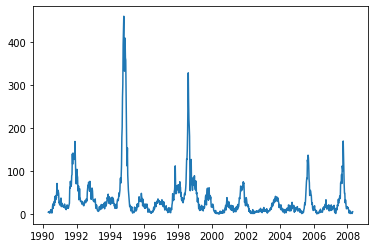

In [7]:
#show time series for both cities 
plt.plot(sj.week_start_date, sj.total_cases)

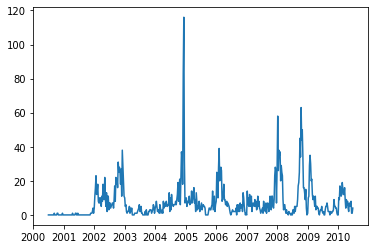

In [8]:
plt.plot(iq.week_start_date, iq.total_cases)

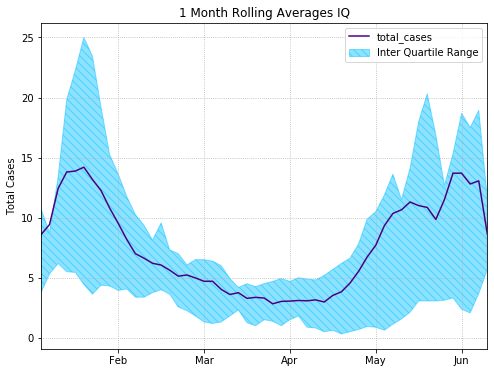

In [9]:
# #plotting rolling averages
# #used previously for hourly data, not working right for weekly data
# # will work on later 

test = iq.loc[:,['week_start_date','total_cases']]
test1 = test.set_index(pd.DatetimeIndex(test['week_start_date']))
test1.drop(columns=['week_start_date'],inplace=True)
season = test1.rolling(window=4, center=True, min_periods=4).mean().groupby(test1.index.weekofyear).mean()
q25 = test1.rolling(window=4, center=True, min_periods=4).mean().groupby(test1.index.weekofyear).quantile(.25)
q75 = test1.rolling(window=4, center=True, min_periods=4).mean().groupby(test1.index.weekofyear).quantile(.75)

f, ax = plt.subplots(figsize=(8,6))

ax.fill_between(season.index,q25.values.ravel(),q75.values.ravel(),color='#00BFFF',hatch='\\\\\\', alpha=0.45, label='Inter Quartile Range')
season.plot(ax=ax, color='#4B0082')
#month_list = pd.date_range('06/01/2015','09/22/2019 23:00:00',freq='24H')
# ax.set_xlabel('Day Of Year')
ax.set_ylabel('Total Cases')
ax.set_title('1 Month Rolling Averages IQ')

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
ax.set_xlabel('')
#ax.xaxis.set_major_locator(months)
ax.set_xticklabels(month_names)
ax.grid(ls=':')

plt.legend()

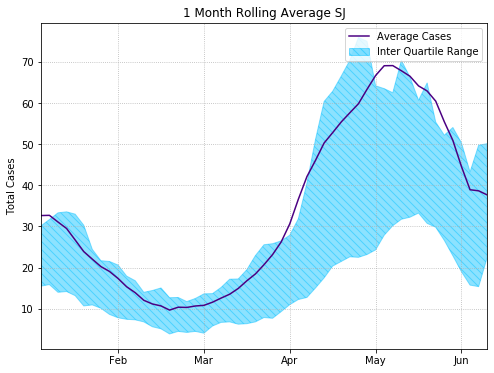

In [10]:
test = pd.DataFrame(sj.loc[:,['week_start_date','total_cases']])
test.rename(columns={'total_cases' : 'Average Cases'}, inplace=True)
test1 = test.set_index(pd.DatetimeIndex(test['week_start_date']))
test1.drop(columns=['week_start_date'],inplace=True)
season = test1.rolling(window=4, center=True).mean().groupby(test1.index.weekofyear).mean()
q25 = test1.rolling(window=4, center=True).mean().groupby(test1.index.weekofyear).quantile(.25)
q75 = test1.rolling(window=4, center=True).mean().groupby(test1.index.weekofyear).quantile(.75)

f, ax = plt.subplots(figsize=(8,6))

ax.fill_between(season.index,q25.values.ravel(),q75.values.ravel(),color='#00BFFF',hatch='\\\\\\', alpha=0.45, label='Inter Quartile Range')
season.plot(ax=ax, color='#4B0082')
#month_list = pd.date_range('06/01/2015','09/22/2019 23:00:00',freq='24H')
# ax.set_xlabel('Day Of Year')
ax.set_ylabel('Total Cases')
ax.set_title('1 Month Rolling Average SJ')

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
ax.set_xlabel('')
#ax.xaxis.set_major_locator(months)
ax.set_xticklabels(month_names)
ax.grid(ls=':')

plt.legend()

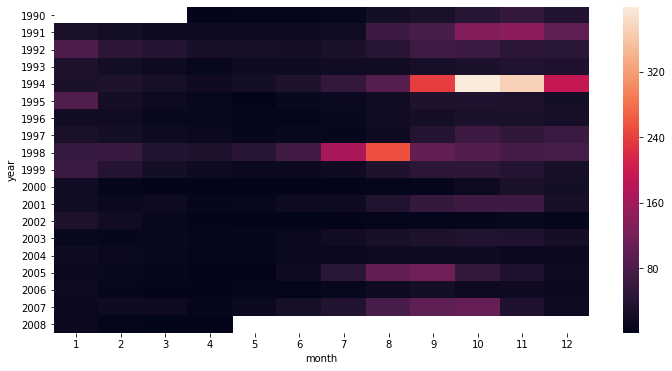

In [11]:
# heat map rather than bar graph for total num cases per month per year
# 

import seaborn as sns

test = sj.loc[:,['week_start_date','y']]
test1 = test.set_index(pd.DatetimeIndex(test['week_start_date']))
test1.drop(columns=['week_start_date'],inplace=True)
test1['month'] = test1.index.month
test1['year'] = test1.index.year
heat = test1.groupby(['year','month']).mean().unstack()
heat.columns = heat.columns.droplevel(0)
f,ax = plt.subplots(figsize=(12,6))
sns.heatmap(heat, ax=ax)

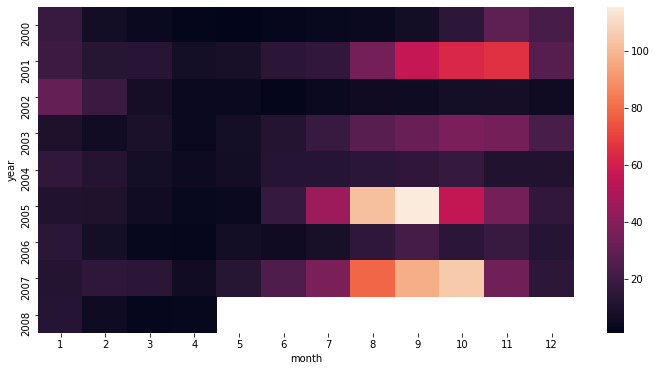

In [12]:
#same heatmap with big years removed so the yearly and bi-yearly trend is a bit more obvious

test = sj.loc[sj.week_start_date.dt.year > 1999,['week_start_date','y']]
test1 = test.set_index(pd.DatetimeIndex(test['week_start_date']))
test1.drop(columns=['week_start_date'],inplace=True)
test1['month'] = test1.index.month
test1['year'] = test1.index.year
heat = test1.groupby(['year','month']).mean().unstack()
heat.columns = heat.columns.droplevel(0)
f,ax = plt.subplots(figsize=(12,6))
sns.heatmap(heat, ax=ax)

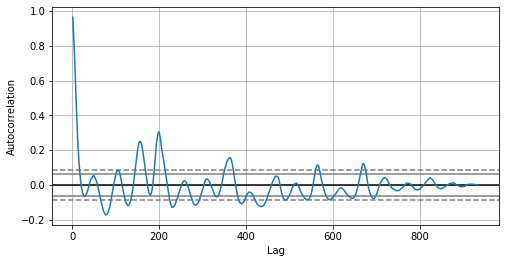

In [13]:
#helps dertime time frame for when the time series trend repeats, more helpful in ARIMA than FBProphet


from pandas.plotting import autocorrelation_plot, scatter_matrix

f, a = plt.subplots(figsize=(8,4))
autocorrelation_plot(sj.loc[:,['week_start_date','y']].set_index('week_start_date'),ax=a)
plt.show()

C:\Users\graha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



26


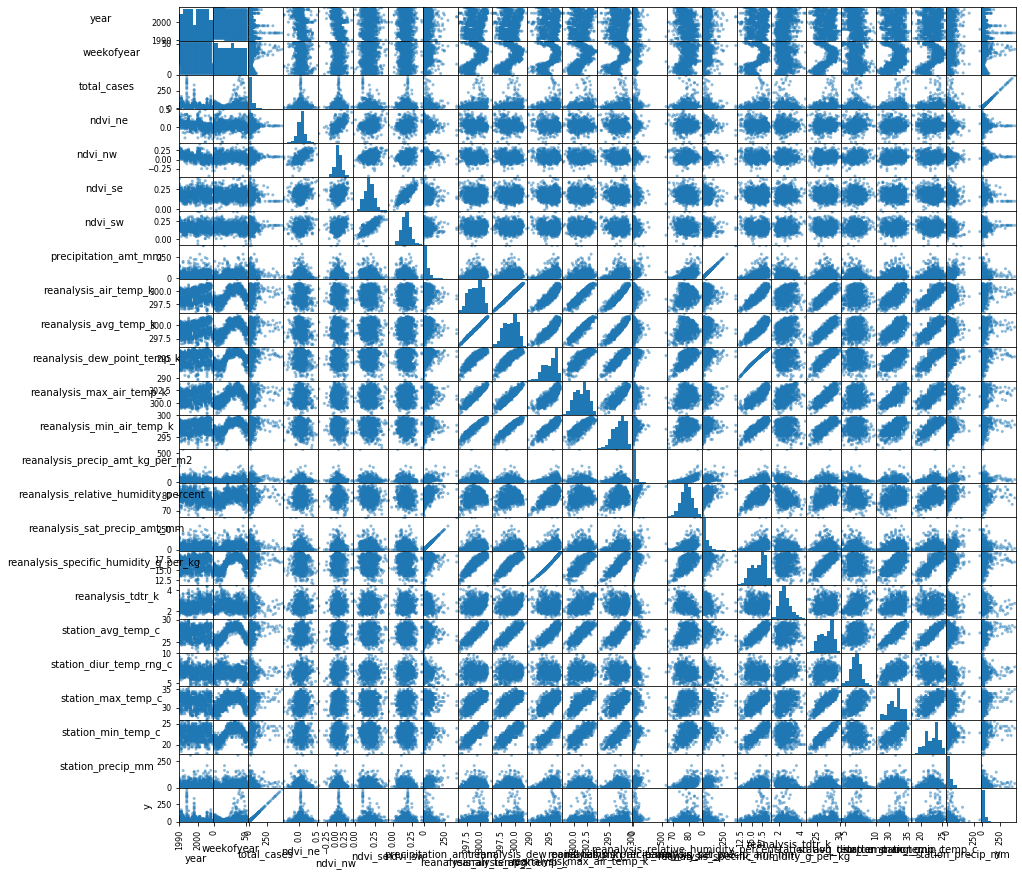

In [14]:
# scatter matrix (used for generating correlation heatmap)
# sometimes visusal is easier to understand than correlation coef for me
# not sure how to get the x labels to rotate, same order so can count how many squares in then cound down to see what
# the x label would be for the square you're interested in

f, axx = plt.subplots(figsize=(15,15))
axs = scatter_matrix(sj, ax=axx)

n = len(sj.columns)
print(n)
for x in range(n-3):
    for y in range(n-3):
        # to get the axis of subplots
        axy = axs[x][y]
        axxx = axs[y][x]
        # to make x axis name vertical  
        axxx.xaxis.label.set_rotation(45)
        # to make y axis name horizontal 
        axy.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        axy.yaxis.labelpad = 50

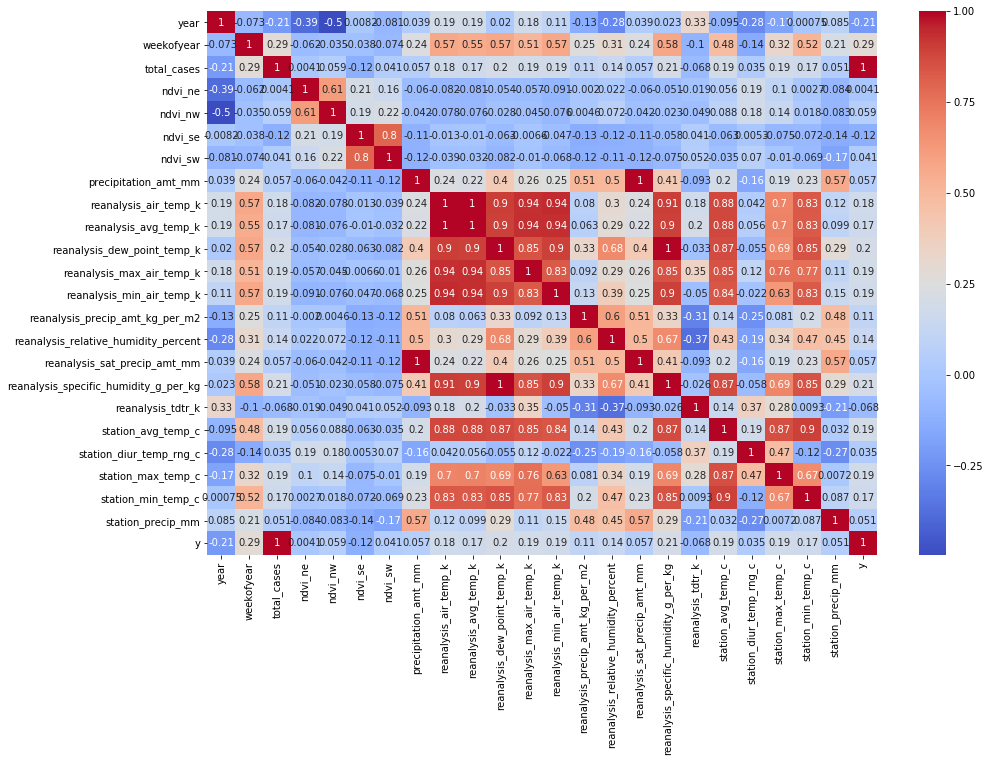

In [15]:
f, ax = plt.subplots(figsize=(15,10))
corr = sj.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           ax=ax,
           annot=True,
           cmap="coolwarm")

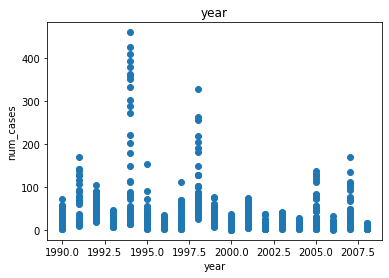

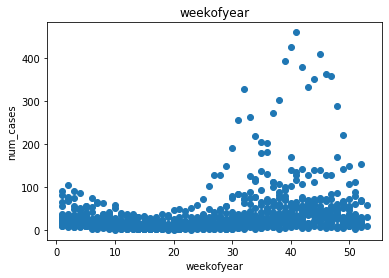

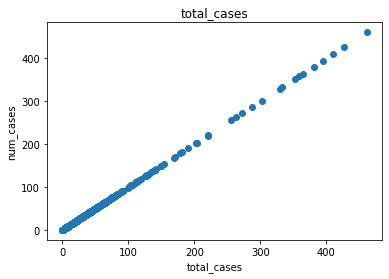

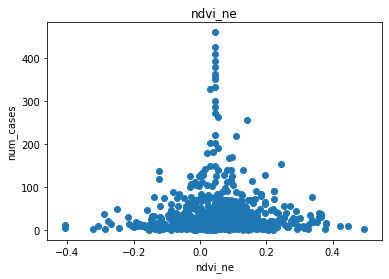

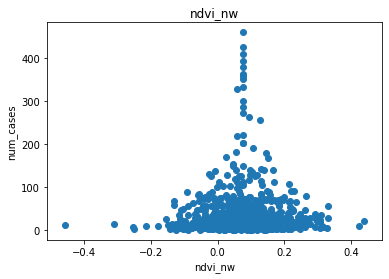

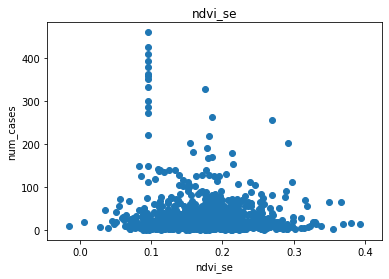

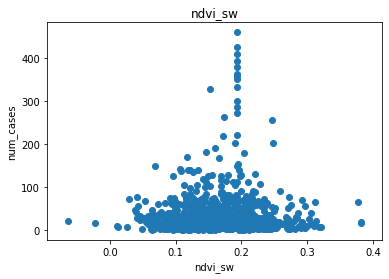

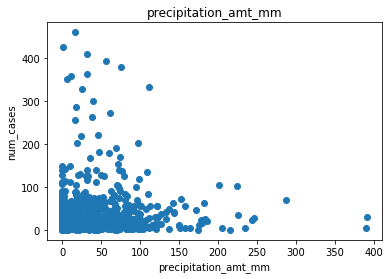

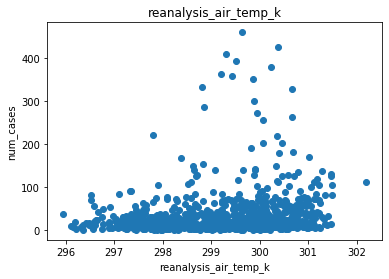

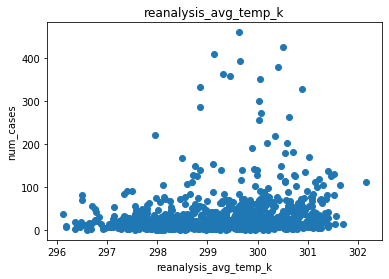

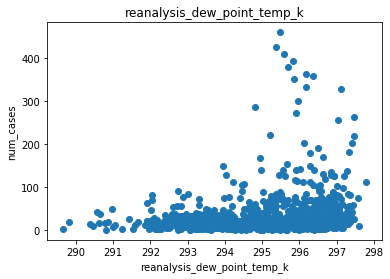

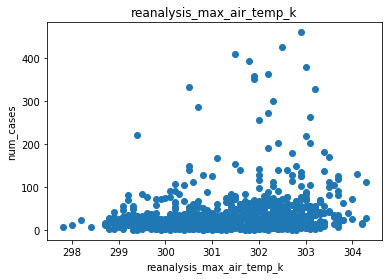

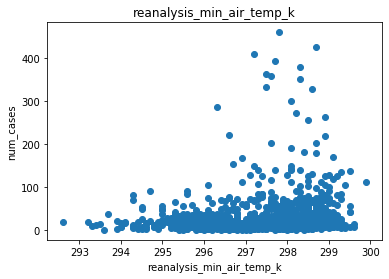

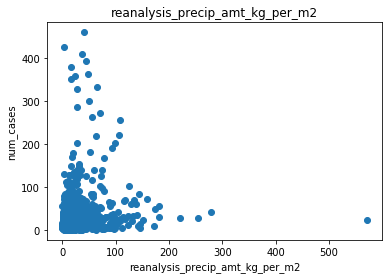

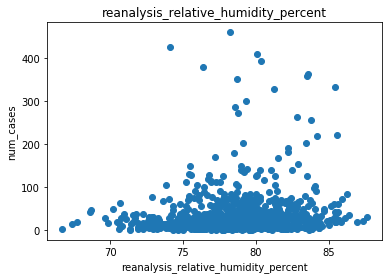

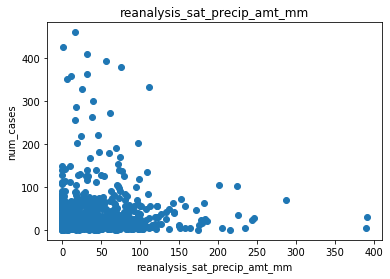

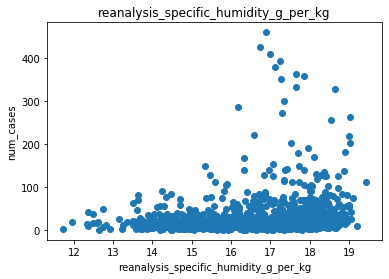

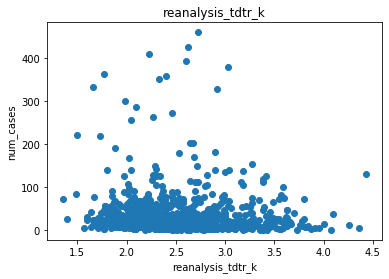

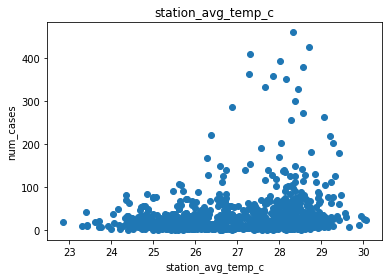

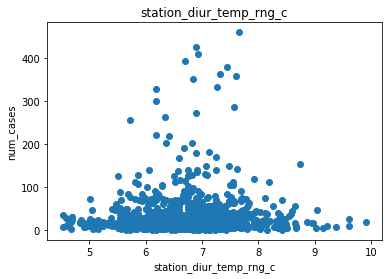

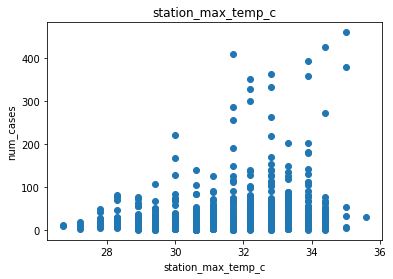

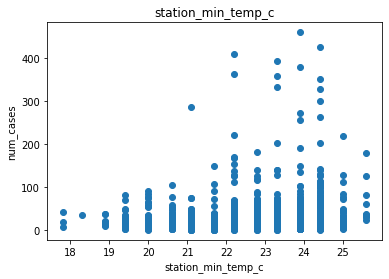

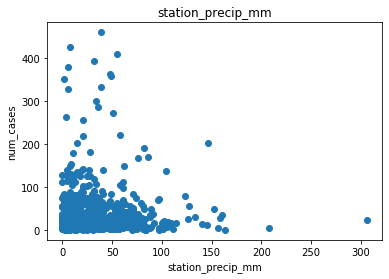

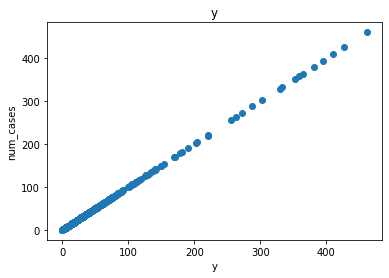

In [16]:
# plots from scatter matrix just showing features correlation with number of cases 
#FBProphet adds in features as "extra_regressors"
#seems as though features with linear correlation with predicted variable are best to use
for col in sj.columns:
    if sj[col].dtype in ['float64','int64']:
        plt.scatter(sj[col],sj['y'])
        plt.title('{}'.format(col))
        plt.xlabel('{}'.format(col))
        plt.ylabel('num_cases')
        plt.show()

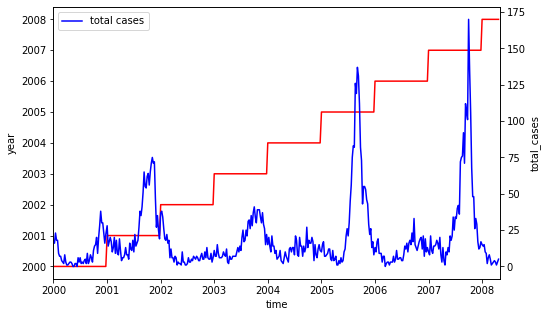

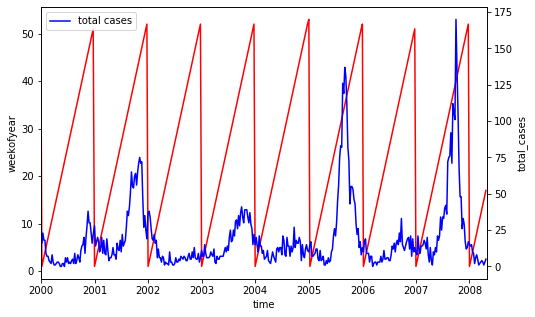

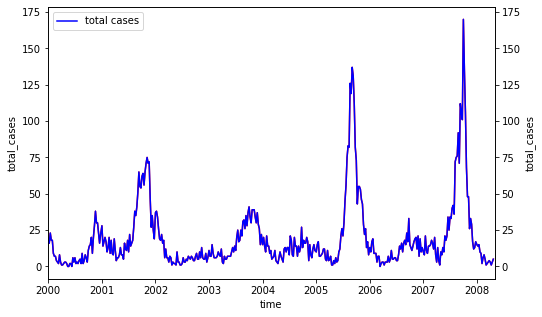

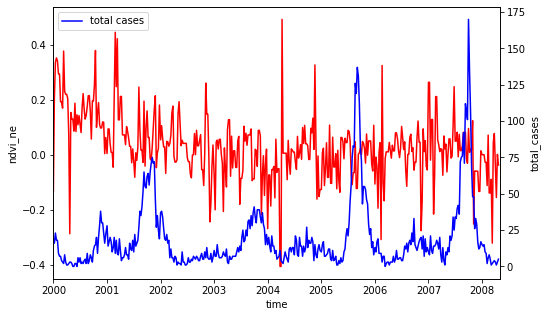

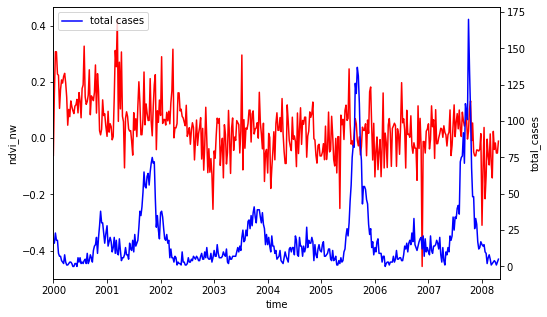

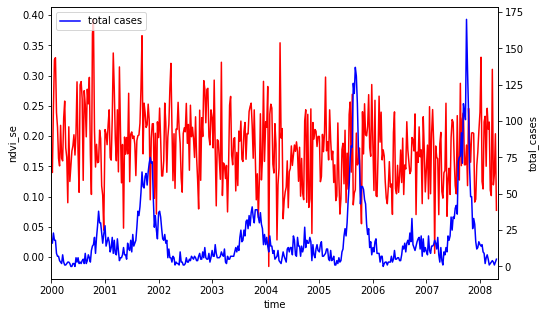

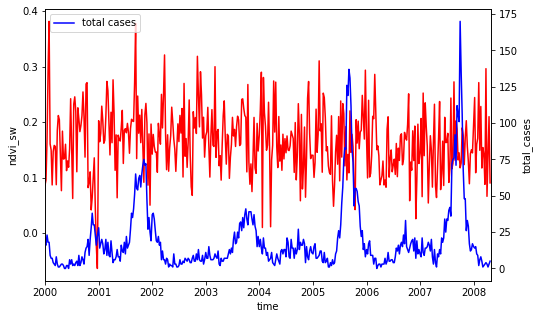

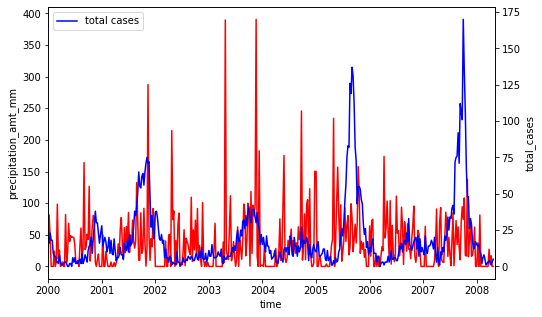

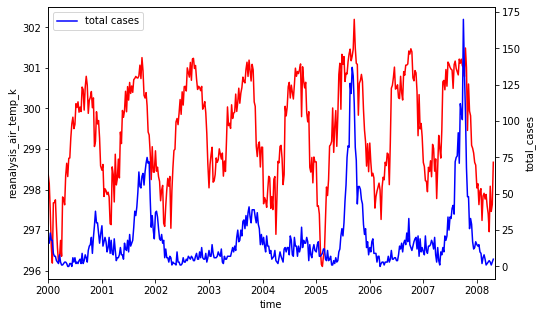

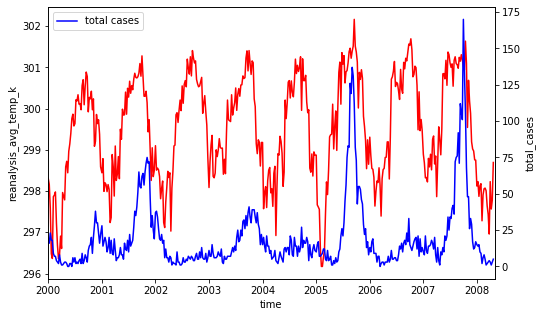

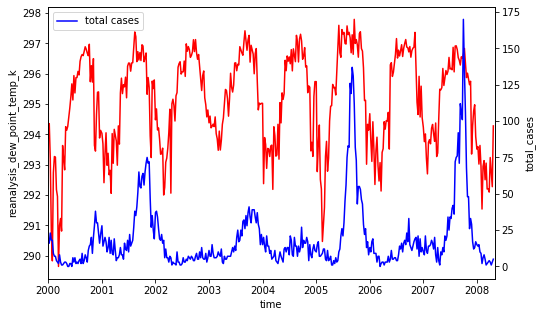

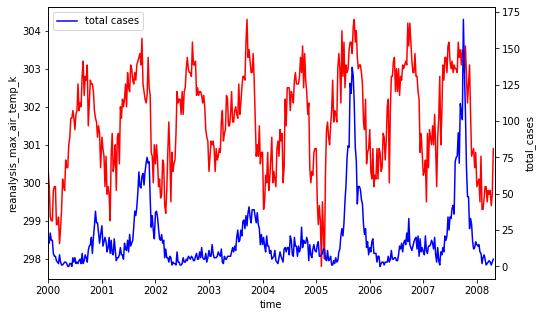

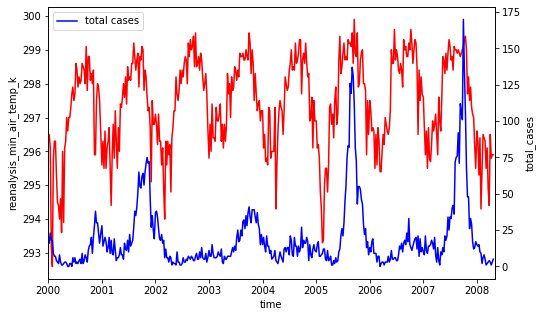

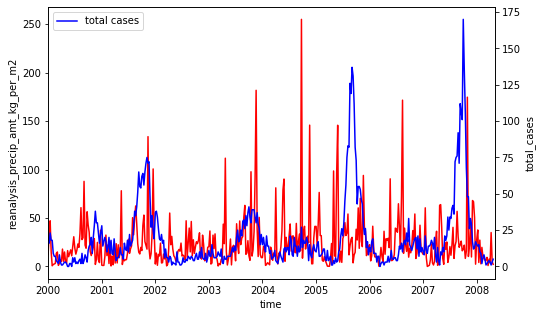

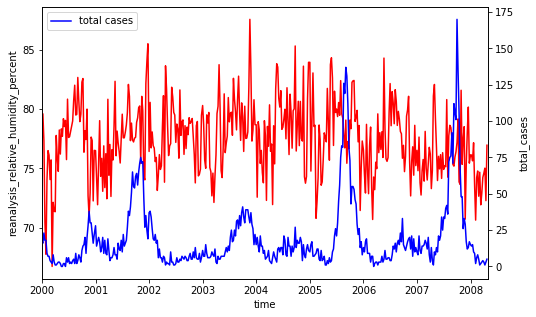

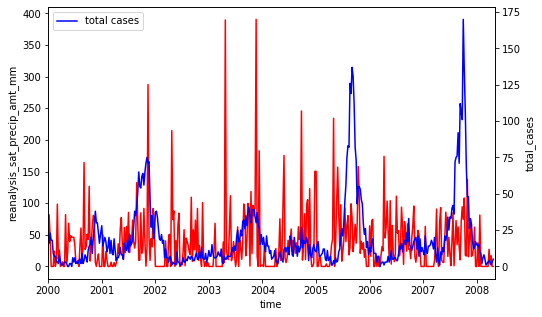

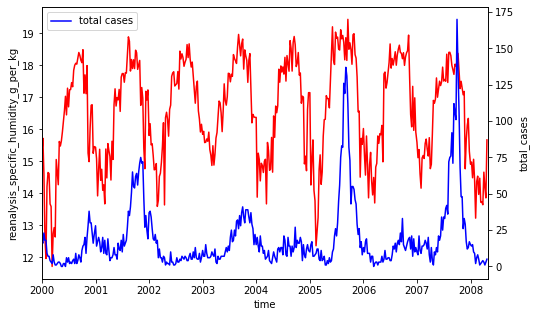

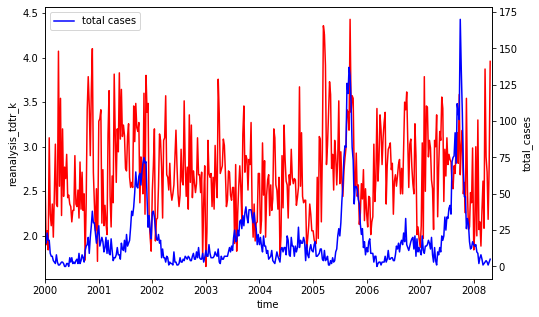

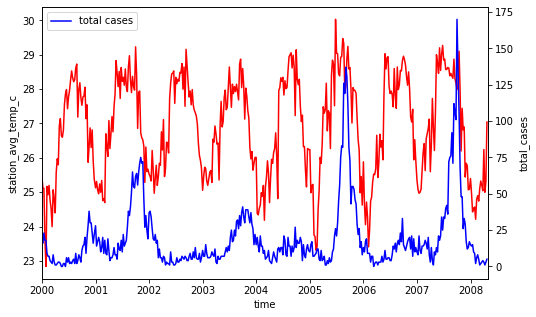

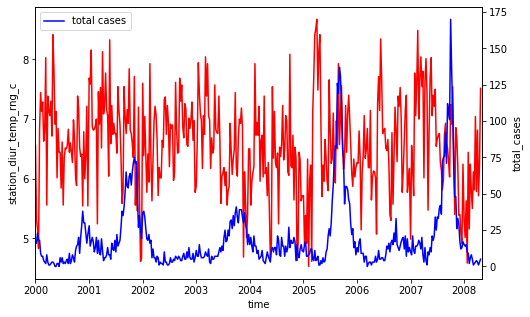

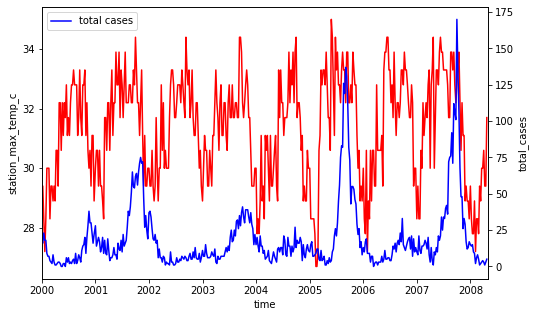

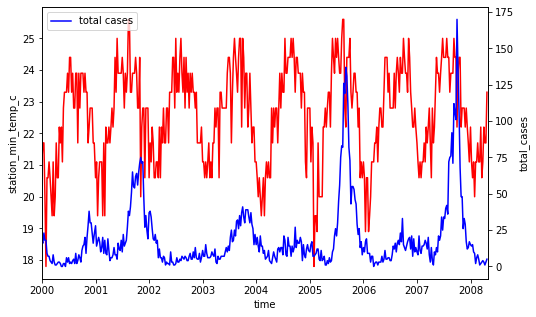

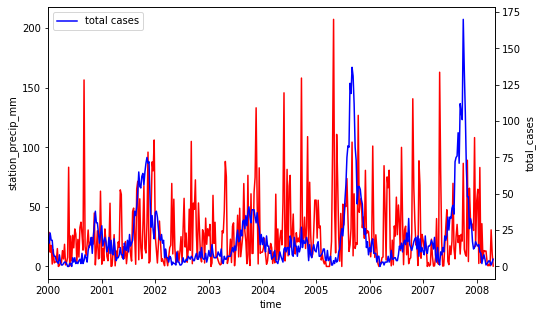

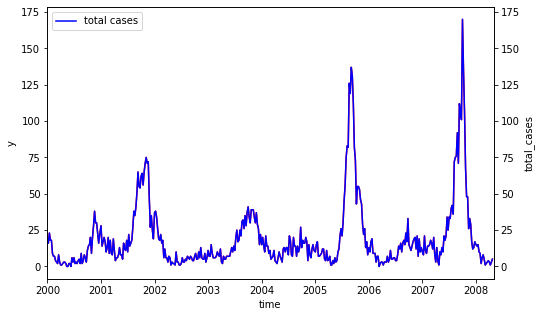

In [17]:
#plotting each feature's time series to see if anything unusual happens in features around big peaks in number of cases
sj_plot = pd.DataFrame(sj.loc[sj.week_start_date.dt.year > 1999,:])
for col in sj.columns:
    if sj[col].dtype in ['float64','int64']:
        f, ax1 = plt.subplots(figsize=(8,5))
        ax1.plot(sj_plot['week_start_date'],sj_plot[col],label='{}'.format(col),c='r')
        ax1.set_xlabel('time')
        ax1.set_ylabel('{}'.format(col))
        ax2 = ax1.twinx()
        ax2.plot(sj_plot['week_start_date'],sj_plot['y'],label='total cases',c='b')
        ax2.set_ylabel('total_cases')
        plt.legend()
        plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2008-05-01'))
        plt.show()

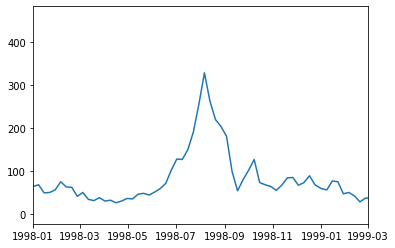

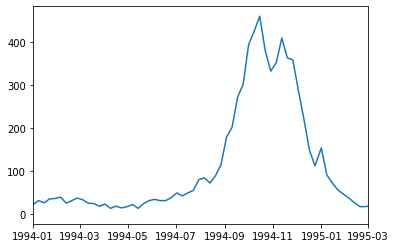

In [18]:
plt.plot(sj['week_start_date'],sj['y'])
plt.xlim(pd.to_datetime('1998-01-01'), pd.to_datetime('1999-03-01'))
plt.show()
plt.plot(sj['week_start_date'],sj['y'])
plt.xlim(pd.to_datetime('1994-01-01'), pd.to_datetime('1995-03-01'))
plt.show()

# Starting Predictions with baseline model

In [19]:
#scaling predictions to reduce the overall trend can help a time series model better understand the trend within each 
#year, month, week, day, ...

#fbprophet has built in normalization of extra regressors (features/columns) so no need to scale them before fitting
#prophet expects dataframe with at least "ds" and "y" columns 

import numpy as np
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

sj_train = pd.DataFrame(sj.loc[:,['week_start_date','y']])
sj_train.rename(columns={'week_start_date':'ds'}, inplace=True)

sj_train.head()
# names are weird, sorry train_train is validation split of our training data 
#splitting off last year of data in sj to use to test to see how well model will predict into future 
sj_train_train = pd.DataFrame(sj_train.loc[sj_train.ds < pd.to_datetime('2007-04-01'),:])
scale.fit(sj_train_train.y.values.reshape(-1,1))
sj_train_test = pd.DataFrame(sj_train.loc[sj_train.ds >= pd.to_datetime('2007-04-01'),:])
sj_train_train.y = scale.transform(sj_train_train.y.values.reshape(-1,1))
sj_train_test.y = scale.transform(sj_train_test.y.values.reshape(-1,1))
sj_train_train.tail()

ds         y
875 2007-02-26 -0.311063
876 2007-03-05 -0.349472
877 2007-03-12 -0.426288
878 2007-03-19 -0.272655
879 2007-03-26 -0.503105

In [20]:
model = Prophet()
model.fit(sj_train_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
#makes a dataframe for the model to use to predict into future
#takes your time period and adds on how long you specify
#52 weeks added here for one year (the one year we cut off)
future = model.make_future_dataframe(periods=52,freq='1W')

In [22]:
forcast = model.predict(future)

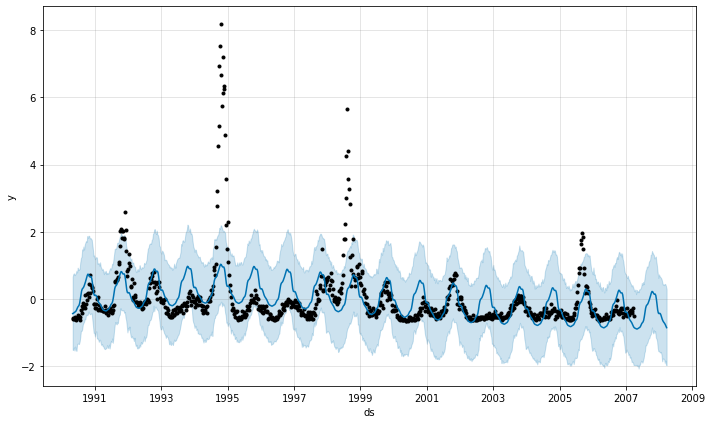

In [23]:
model.plot(forcast)
plt.show()

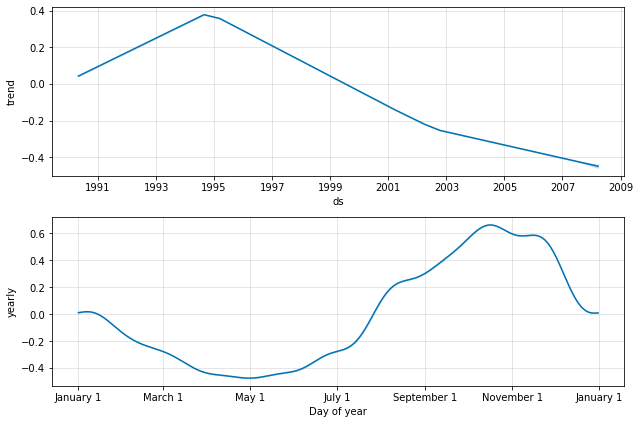

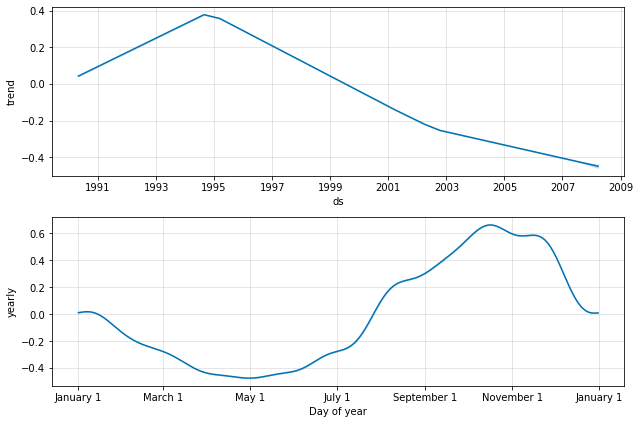

In [24]:
#show the trends that the model is pulling out of the data 
model.plot_components(forcast)

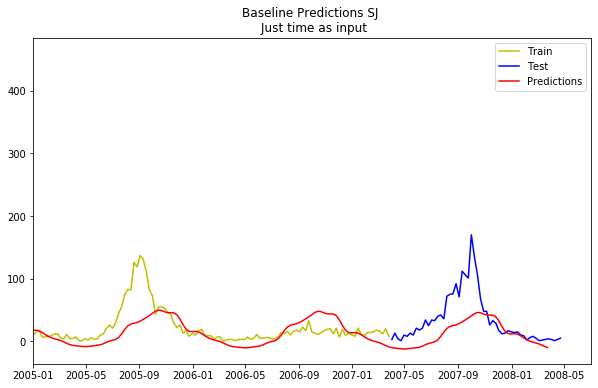

In [25]:
f#plot predictions vs true and testing set
plt.figure(figsize=(10,6))
plt.plot(sj_train_train['ds'], 
            scale.inverse_transform(sj_train_train['y'].values.reshape(-1,1)), c='y',label="Train")
plt.plot(sj_train_test['ds'],
            scale.inverse_transform(sj_train_test['y'].values.reshape(-1,1)),c='b',label="Test")
plt.plot(forcast['ds'],
            scale.inverse_transform(forcast['yhat'].values.reshape(-1,1)),c='r',label="Predictions")
plt.xlim(pd.to_datetime('2005-01-01'), pd.to_datetime('2008-07-01'))
plt.legend()
plt.title('Baseline Predictions SJ \n Just time as input')
plt.show()

In [26]:
# next 3 are built in metrics 
# hard to explain in just comments 
# can read about under "diagnostics" on fbprophet if interested 
# overall better than just cuttinf off last year, last year just easy to absorb
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='500 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 30 forecasts with cutoffs between 1991-12-10 00:00:00 and 2006-03-26 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 1991-12-17  1.435351    1.210085    1.652420  0.841185 1991-12-10
1 1991-12-24  1.232156    0.985947    1.446059  0.687552 1991-12-10
2 1992-01-01  1.214761    0.973209    1.440169  0.898797 1991-12-10
3 1992-01-08  1.344516    1.105532    1.593683  1.340493 1991-12-10
4 1992-01-15  1.475398    1.263287    1.711165  1.071635 1991-12-10

In [27]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape  coverage
0 37 days  0.521991  0.722490  0.557346  8.833724  0.807692
1 38 days  0.509990  0.714136  0.548864  8.830425  0.799451
2 39 days  0.502277  0.708715  0.543890  8.827474  0.802885
3 40 days  0.521283  0.722000  0.560325  8.939915  0.794872
4 42 days  0.518149  0.719826  0.558331  8.933265  0.788462

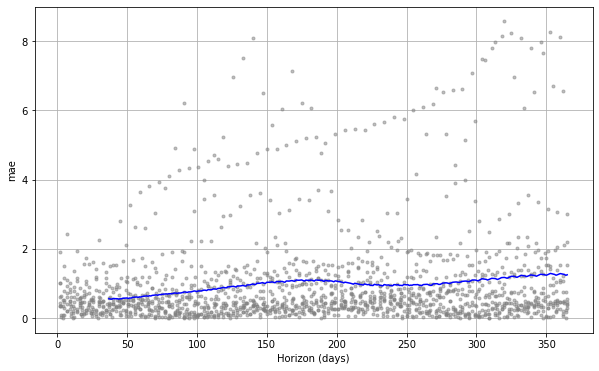

In [28]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

# Tuning model and adding in some features

In [29]:
sj.columns

Index(['city', 'year', 'weekofyear', 'total_cases', 'week_start_date',
       'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'y'],
      dtype='object')

In [30]:
from sklearn.preprocessing import MinMaxScaler
# Can change between minmax and standard with following line, for testing 
scale = StandardScaler()
#add some more columns in to training data, tried not to overlap in category too much
sj_train = pd.DataFrame(sj.loc[sj.week_start_date.dt.year > 1999,['week_start_date','y','station_precip_mm','ndvi_ne',
                                 'ndvi_sw','reanalysis_relative_humidity_percent','station_diur_temp_rng_c',
                                              'reanalysis_avg_temp_k','station_min_temp_c','station_max_temp_c','reanalysis_dew_point_temp_k',
                                                                 'reanalysis_precip_amt_kg_per_m2']])
sj_train.rename(columns={'week_start_date':'ds'}, inplace=True)
# sj_train['cap'] = np.max(sj_train['y'])

sj_train.head()
sj_train_train = pd.DataFrame(sj_train.loc[sj_train.ds < pd.to_datetime('2007-04-01'),:])
print(sj_train_train.y.median(),sj_train_train.y.mean())
scale.fit(sj_train_train.y.values.reshape(-1,1))
sj_train_test = pd.DataFrame(sj_train.loc[sj_train.ds >= pd.to_datetime('2007-04-01'),:])
print(sj_train_test.y.median(),sj_train_test.y.mean())
sj_train_train.y = scale.transform(sj_train_train.y.values.reshape(-1,1))
sj_train_test.y = scale.transform(sj_train_test.y.values.reshape(-1,1))
#commented out cap lines are for growth='logistic'
# sj_train_test.cap = scale.transform(sj_train_test.cap.values.reshape(-1,1))
# sj_train_train.cap = scale.transform(sj_train_train.cap.values.reshape(-1,1))
sj_train_train.tail()



11.0 17.23342175066313
17.0 33.910714285714285


ds         y  station_precip_mm  ndvi_ne   ndvi_sw  \
875 2007-02-26  0.038289               22.9  0.21210  0.054383   
876 2007-03-05 -0.061607                8.4  0.05430  0.120857   
877 2007-03-12 -0.261398                0.3  0.03730  0.175486   
878 2007-03-19  0.138184                0.5  0.01170  0.149200   
879 2007-03-26 -0.461189                7.6  0.02285  0.082957   

     reanalysis_relative_humidity_percent  station_diur_temp_rng_c  \
875                             78.125714                 7.000000   
876                             75.014286                 7.671429   
877                             74.025714                 8.042857   
878                             75.438571                 7.542857   
879                             76.784286                 7.800000   

     reanalysis_avg_temp_k  station_min_temp_c  station_max_temp_c  \
875             298.514286                21.1                31.7   
876             299.250000                22.2                32.2   
877             299.335714                21.7                31.7   
878             298.657143                22.2                32.8   
879             298.850000                22.8                33.3   

     reanalysis_dew_point_temp_k  reanalysis_precip_amt_kg_per_m2  
875                   294.204286                            23.12  
876                   294.328571                             3.70  
877                   294.020000                             1.50  
878                   293.770000                             5.10  
879                   294.375714                            25.20

In [31]:
#add in regressors and tune parameters.  Fourier and prior scale have to do with how flexible the model is to changes
#higher number is model responds more strongly to that input, changepoint is on a smaller scale than seasonality and regressors
model = Prophet(changepoint_range=.75, growth='linear',yearly_seasonality=False, changepoint_prior_scale=.8)
model.add_seasonality(period=365*2,name='bi-anual',fourier_order=10, prior_scale=20)
model.add_regressor('station_precip_mm', mode='additive',prior_scale=8)
model.add_regressor('ndvi_ne',standardize=True, mode='additive',prior_scale=2)
# model.add_regressor('ndvi_nw',standardize=True, mode='additive',prior_scale=10)
model.add_regressor('ndvi_sw',standardize=True, mode='additive',prior_scale=2)
# model.add_regressor('ndvi_se',standardize=True, mode='additive')
model.add_regressor('reanalysis_relative_humidity_percent',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('station_diur_temp_rng_c',standardize=True, mode='additive',prior_scale=10)
model.add_regressor('reanalysis_avg_temp_k',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('station_min_temp_c',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('station_max_temp_c',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('reanalysis_dew_point_temp_k',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('reanalysis_precip_amt_kg_per_m2',standardize=True, mode='additive',prior_scale=10)



model.fit(sj_train_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = model.make_future_dataframe(periods=52*1,freq='1W')
#furture dataframe needs the extra regressor columns, so in real world need to be able to also predict all of the 
#feature variables
#merge with existing one to get last year of data 
#fbprophet uses built in scaling again
sj_merge = pd.DataFrame(sj_train.loc[:,['ds','station_precip_mm','cap','ndvi_ne',
                                 'ndvi_sw','reanalysis_relative_humidity_percent','station_diur_temp_rng_c',
                                              'reanalysis_avg_temp_k','station_min_temp_c','station_max_temp_c','reanalysis_dew_point_temp_k',
                                       'reanalysis_precip_amt_kg_per_m2']])

future_n = pd.merge(sj_merge.set_index(pd.DatetimeIndex(sj_merge['ds'])), 
                    future.set_index(pd.DatetimeIndex(future['ds'])), 
                    how='left', left_index=True, right_index=True)
future_n = future_n.reset_index()
future_n.drop(columns=['ds_x','ds_y'], inplace=True)
# future_n.cap = scale.transform(future_n.cap.values.reshape(-1,1))
future_n.head()

C:\Users\graha\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



ds  station_precip_mm  cap  ndvi_ne   ndvi_sw  \
0 2000-01-01                7.9  NaN -0.13360  0.086311   
1 2000-01-08               28.6  NaN  0.20635  0.095833   
2 2000-01-15               12.0  NaN  0.33700  0.168629   
3 2000-01-22               17.7  NaN  0.35300  0.291429   
4 2000-01-29                2.0  NaN  0.34190  0.381420   

   reanalysis_relative_humidity_percent  station_diur_temp_rng_c  \
0                             76.317143                 6.557143   
1                             79.607143                 5.314286   
2                             77.342857                 5.157143   
3                             70.457143                 4.828571   
4                             67.765714                 6.842857   

   reanalysis_avg_temp_k  station_min_temp_c  station_max_temp_c  \
0             298.307143                21.1                29.4   
1             298.164286                21.7                29.4   
2             297.585714                21.7                28.3   
3             296.478571                20.0                27.2   
4             296.364286                17.8                28.3   

   reanalysis_dew_point_temp_k  reanalysis_precip_amt_kg_per_m2  
0                   293.887143                            12.34  
1                   294.355714                            32.30  
2                   293.191429                            47.10  
3                   290.852857                            14.70  
4                   289.827143                             0.70

In [33]:
forcast = model.predict(future_n)
forcast.tail()

ds     trend  cap  yhat_lower  yhat_upper  trend_lower  \
428 2008-03-25  0.540885  NaN   -2.728140    1.516676    -1.508397   
429 2008-04-01  0.543713  NaN   -2.573482    1.877851    -1.582068   
430 2008-04-08  0.546541  NaN   -2.611138    1.934438    -1.672446   
431 2008-04-15  0.549368  NaN   -2.799600    1.810388    -1.745444   
432 2008-04-22  0.552196  NaN   -2.798381    1.927305    -1.819556   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
428     2.593462       -1.114004             -1.114004             -1.114004   
429     2.658503       -0.924371             -0.924371             -0.924371   
430     2.740541       -0.901921             -0.901921             -0.901921   
431     2.797267       -0.984877             -0.984877             -0.984877   
432     2.899160       -1.050770             -1.050770             -1.050770   

     ...  station_min_temp_c  station_min_temp_c_lower  \
428  ...            0.080554                  0.080554   
429  ...            0.019872                  0.019872   
430  ...            0.047455                  0.047455   
431  ...            0.047455                  0.047455   
432  ...           -0.040811                 -0.040811   

     station_min_temp_c_upper  station_precip_mm  station_precip_mm_lower  \
428                  0.080554           0.001424                 0.001424   
429                  0.019872           0.001495                 0.001495   
430                  0.047455          -0.000146                -0.000146   
431                  0.047455           0.000914                 0.000914   
432                 -0.040811           0.001506                 0.001506   

     station_precip_mm_upper  multiplicative_terms  \
428                 0.001424                   0.0   
429                 0.001495                   0.0   
430                -0.000146                   0.0   
431                 0.000914                   0.0   
432                 0.001506                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
428                         0.0                         0.0 -0.573118  
429                         0.0                         0.0 -0.380658  
430                         0.0                         0.0 -0.355380  
431                         0.0                         0.0 -0.435509  
432                         0.0                         0.0 -0.498574  

[5 rows x 50 columns]

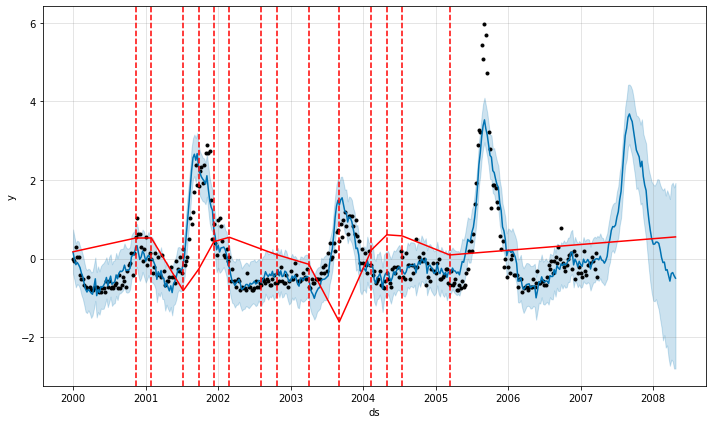

In [34]:
from fbprophet.plot import add_changepoints_to_plot
#add visualization for change point
#good for tweaking stuff, before changes there were 0 changepoints, had to increase prior_scale
fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), model, forcast)

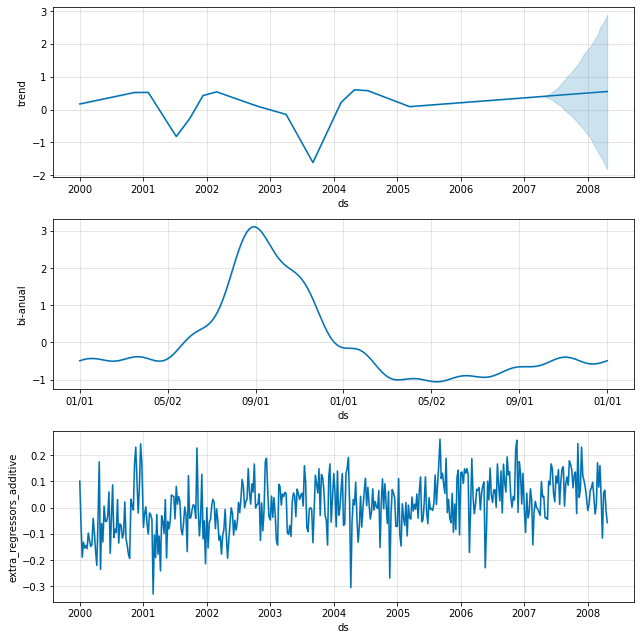

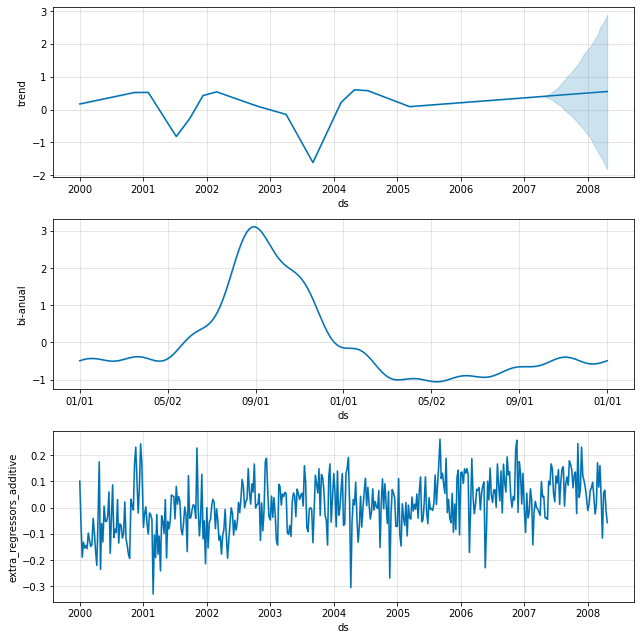

In [35]:
model.plot_components(forcast)
#bi-anual seasonality addition helps accuracy, but messes with yearly trend, need to fix it or just turn off yearly 

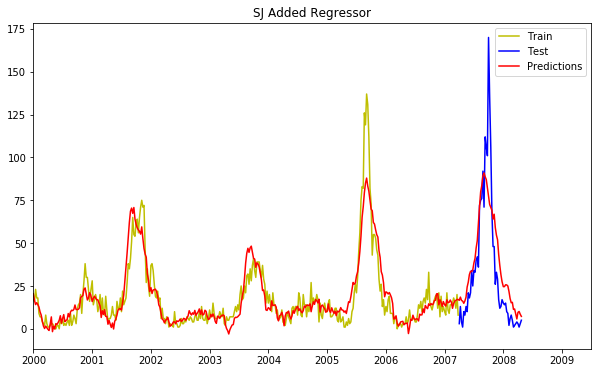

In [36]:
#vis results
plt.figure(figsize=(10,6))
plt.plot(sj_train_train['ds'], 
            scale.inverse_transform(sj_train_train['y'].values.reshape(-1,1)), c='y',label="Train")
plt.plot(sj_train_test['ds'],
            scale.inverse_transform(sj_train_test['y'].values.reshape(-1,1)),c='b',label="Test")
plt.plot(forcast['ds'],
            scale.inverse_transform(forcast['yhat'].values.reshape(-1,1)),c='r',label="Predictions")
# plt.plot(sj_train_train['ds'], 
#             sj_train_train['y']**3, c='y',label="Train")
# plt.plot(sj_train_test['ds'],
#             sj_train_test['y']**3,c='b',label="Test")
# plt.plot(forcast['ds'],
#             forcast['yhat']**3,c='r',label="Predictions")

plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2009-07-01'))
plt.legend()
plt.title('SJ Added Regressor')
plt.show()

In [37]:
#write predictions to csv and json
def fill_0(value):
    if value < 0:
        return 0
    else:
        return int(value)
    

train = pd.DataFrame(sj_train_train.loc[:,['ds','y']])
test = pd.DataFrame(sj_train_test.loc[:,['ds','y']])
train.y = scale.inverse_transform(train.y)
test.y = scale.inverse_transform(test.y)
predictions = pd.DataFrame(forcast.loc[:,['ds','yhat']])
predictions.yhat = scale.inverse_transform(predictions.yhat)
predictions.yhat = predictions.yhat.apply(fill_0)
train.y = train.y.astype(int)
test.y = test.y.astype(int)
train.to_csv('sj_train.csv',date_format='%Y-%m-%d',index=False)
test.to_csv('sj_test.csv',date_format='%Y-%m-%d',index=False)
predictions.to_csv('sj_predictions.csv',date_format='%Y-%m-%d',index=False)


Train R2 0.8111975931658706
Test R2 0.7072923205380854
Train MAE 5.670625508622303
Test MAE 14.648843379737281


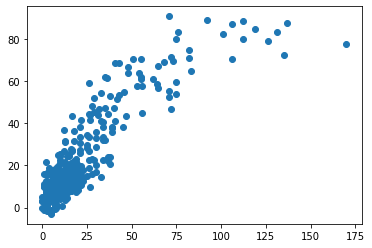

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error
#train and test r2
#model still can't quite predict the huge jump in testng year of 2008

plt.scatter(sj_train['y'],scale.inverse_transform(forcast['yhat'].values.reshape(-1,1)))
print('Train R2',r2_score(scale.inverse_transform(sj_train_train['y'].values.reshape(-1,1)),scale.inverse_transform(forcast.loc[forcast.ds < pd.to_datetime('2007-04-01'), 'yhat'].values.reshape(-1,1)).reshape(len(sj_train_train),)))
print('Test R2',r2_score(scale.inverse_transform(sj_train_test['y'].values.reshape(-1,1)),scale.inverse_transform(forcast.loc[forcast.ds >= pd.to_datetime('2007-04-01'), 'yhat'].values.reshape(-1,1)).reshape(len(sj_train_test),)))
print('Train MAE',mean_absolute_error(scale.inverse_transform(sj_train_train['y'].values.reshape(-1,1)),scale.inverse_transform(forcast.loc[forcast.ds < pd.to_datetime('2007-04-01'), 'yhat'].values.reshape(-1,1)).reshape(len(sj_train_train),)))
print('Test MAE',mean_absolute_error(scale.inverse_transform(sj_train_test['y'].values.reshape(-1,1)),scale.inverse_transform(forcast.loc[forcast.ds >= pd.to_datetime('2007-04-01'), 'yhat'].values.reshape(-1,1)).reshape(len(sj_train_test),)))

In [39]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '730 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2002-04-11 00:00:00 and 2005-03-26 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2002-04-16 -0.673215   -0.954690   -0.390355 -0.561085 2002-04-11
1 2002-04-23 -0.702979   -0.983063   -0.405189 -0.810823 2002-04-11
2 2002-04-30 -0.704011   -0.981595   -0.425226 -0.710928 2002-04-11
3 2002-05-07 -0.854778   -1.136495   -0.559519 -0.760876 2002-04-11
4 2002-05-14 -0.672167   -0.942143   -0.386525 -0.760876 2002-04-11

In [40]:
df_p = performance_metrics(df_cv)
df_p.head()


horizon       mse      rmse       mae      mape  coverage
0 73 days  0.367209  0.605978  0.427196  2.308222  0.513889
1 75 days  0.369454  0.607827  0.431300  2.351235  0.513889
2 77 days  0.371963  0.609888  0.433859  2.366583  0.513889
3 78 days  0.370178  0.608422  0.429857  2.360155  0.520833
4 80 days  0.382910  0.618797  0.441136  2.500510  0.500000

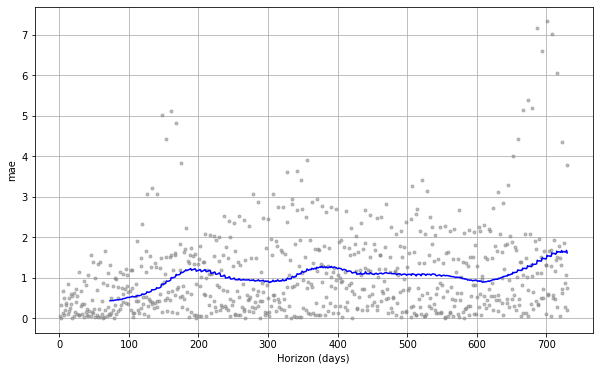

In [41]:

fig = plot_cross_validation_metric(df_cv, metric='mae')

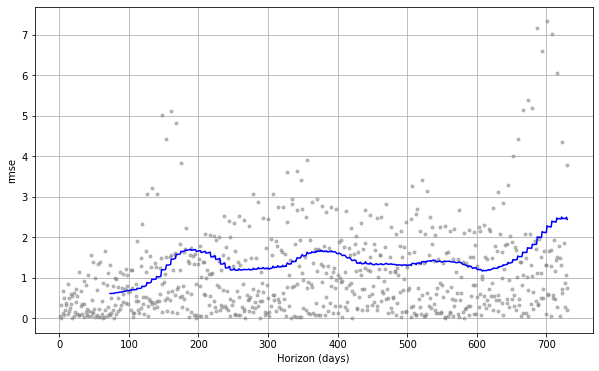

In [42]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

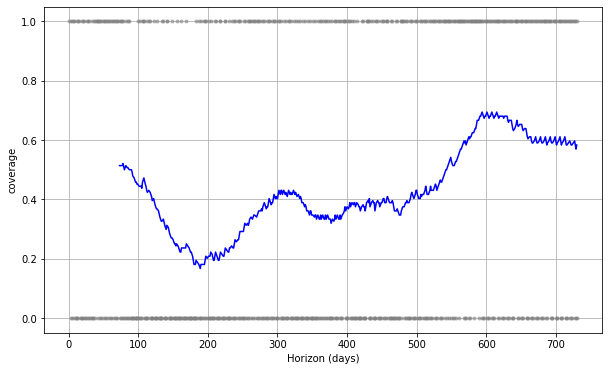

In [43]:
fig = plot_cross_validation_metric(df_cv, metric='coverage')

(-5, 50)

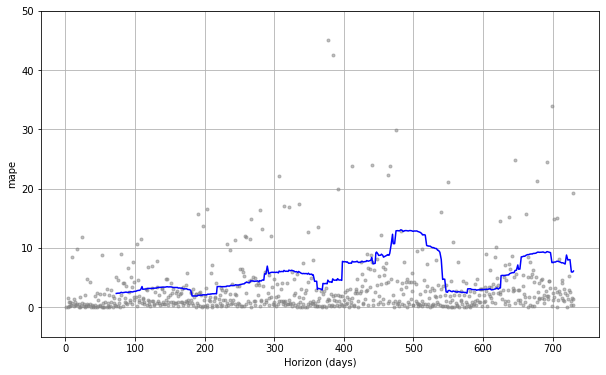

In [44]:
f, ax = plt.subplots(figsize=(10,6))
plot_cross_validation_metric(df_cv, metric='mape',ax=ax)
ax.set_ylim(-5,50)

# Now Starting with IQ data

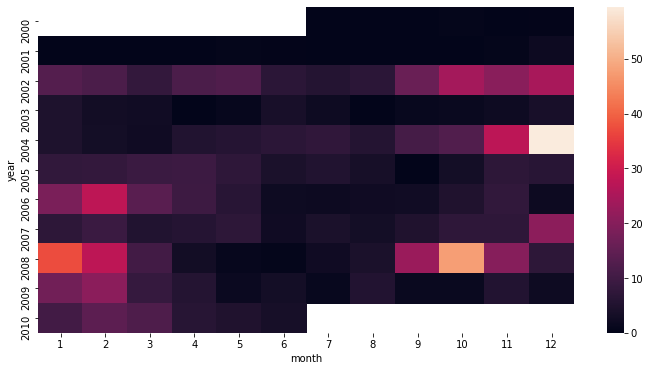

In [45]:
test = iq.loc[:,['week_start_date','y']]
test1 = test.set_index(pd.DatetimeIndex(test['week_start_date']))
test1.drop(columns=['week_start_date'],inplace=True)
test1['month'] = test1.index.month
test1['year'] = test1.index.year
heat = test1.groupby(['year','month']).mean().unstack()
heat.columns = heat.columns.droplevel(0)
f,ax = plt.subplots(figsize=(12,6))
sns.heatmap(heat, ax=ax)

C:\Users\graha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



26


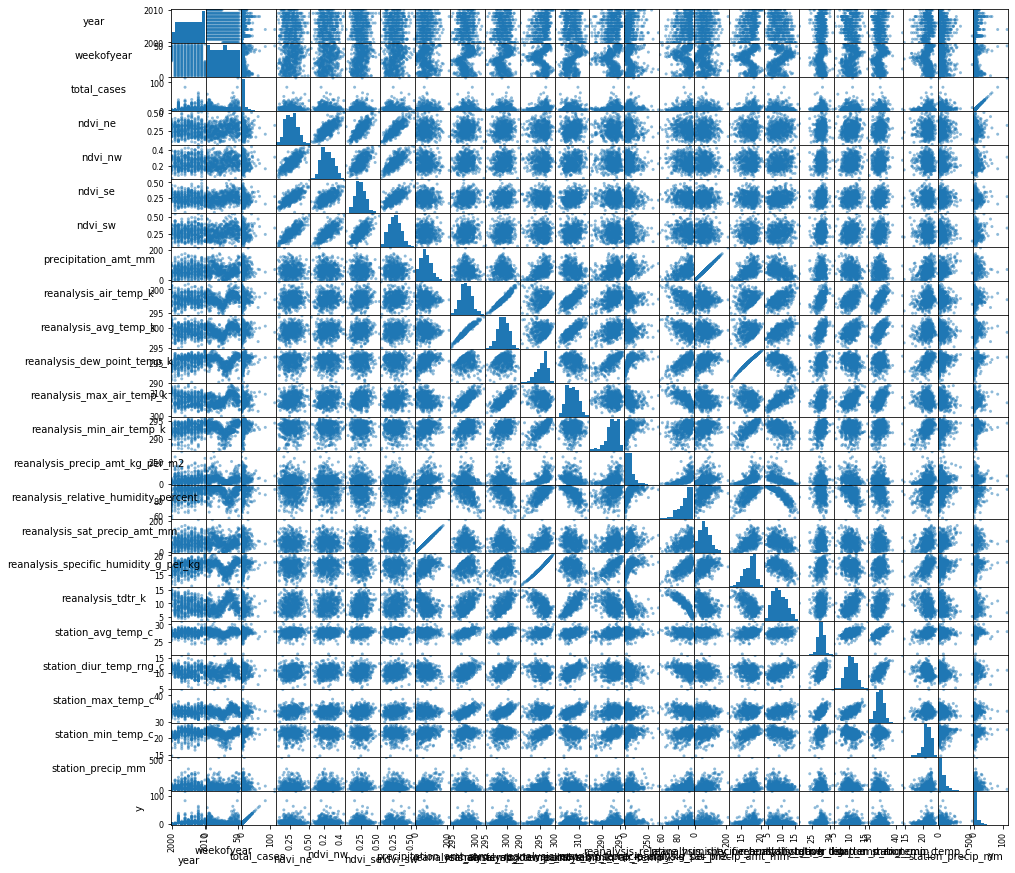

In [46]:
f, axx = plt.subplots(figsize=(15,15))
axs = scatter_matrix(iq, ax=axx)

n = len(iq.columns)
print(n)
for x in range(n-3):
    for y in range(n-3):
        # to get the axis of subplots
        axy = axs[x][y]
        axxx = axs[y][x]
        # to make x axis name vertical  
        axxx.xaxis.label.set_rotation(45)
        # to make y axis name horizontal 
        axy.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        axy.yaxis.labelpad = 50

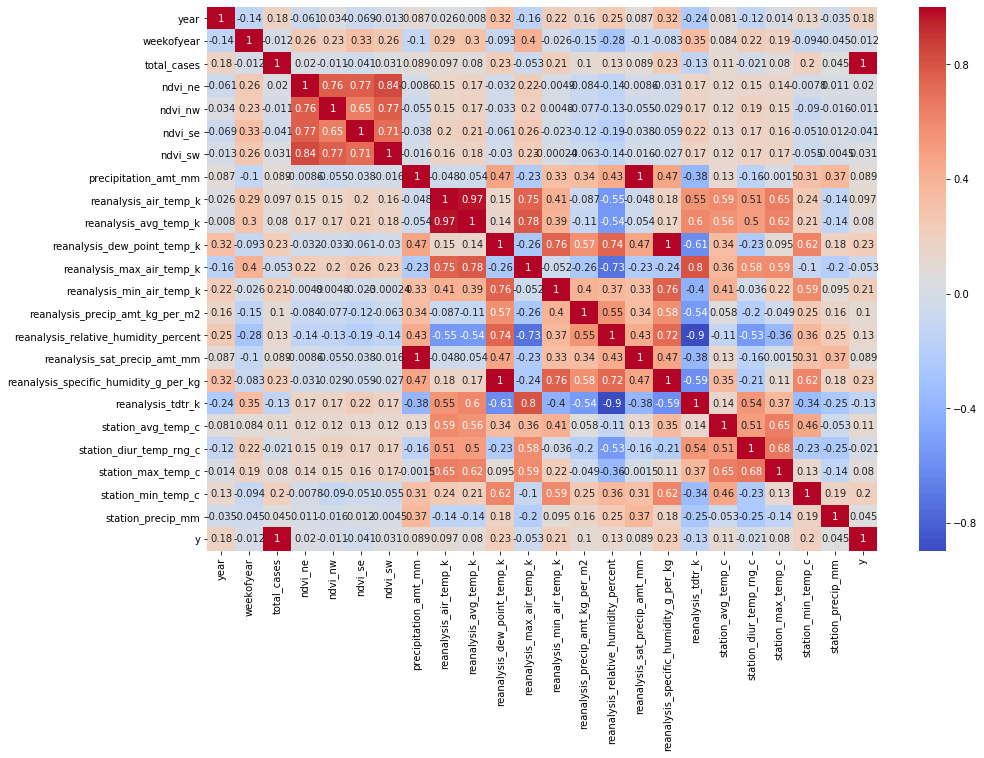

In [47]:
f, ax = plt.subplots(figsize=(15,10))
corr = iq.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           ax=ax,
           annot=True,
           cmap="coolwarm")

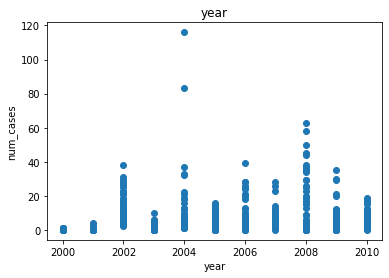

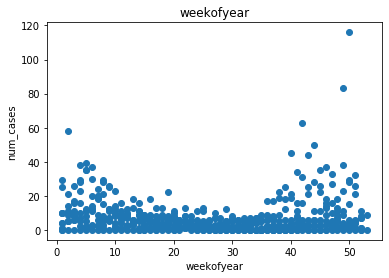

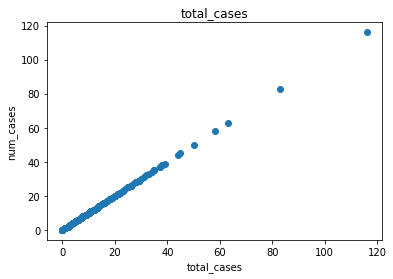

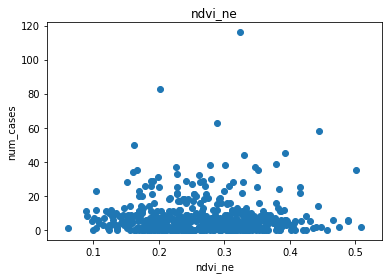

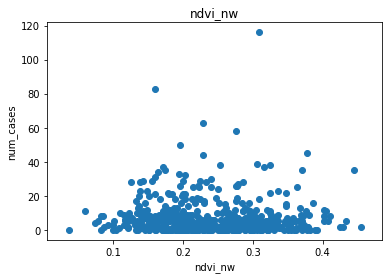

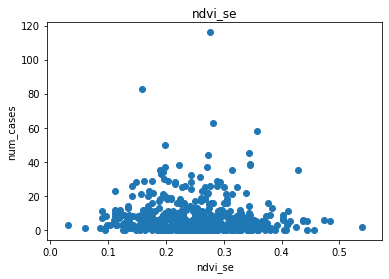

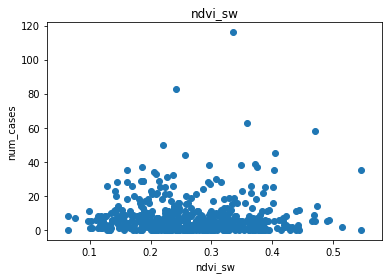

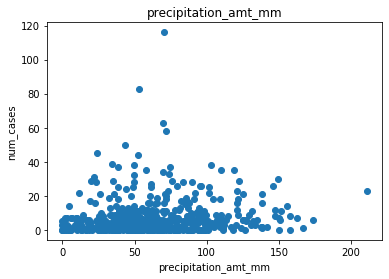

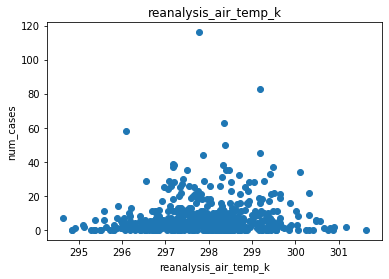

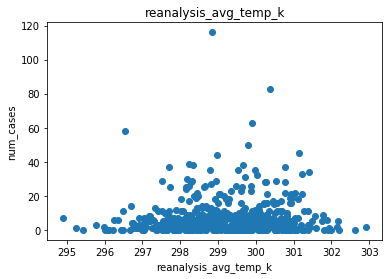

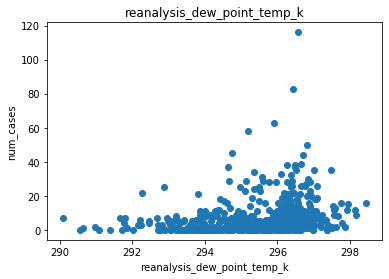

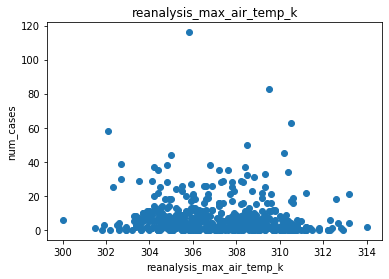

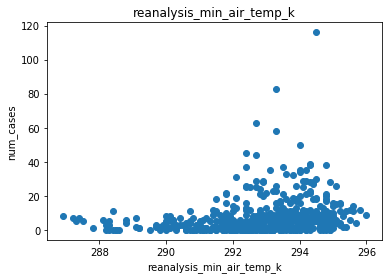

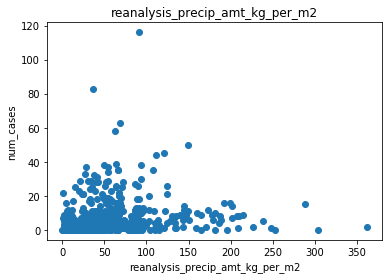

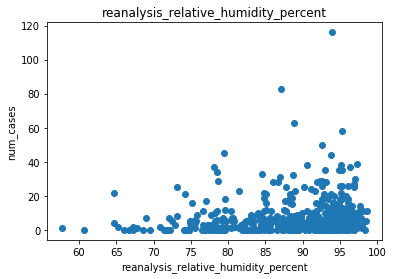

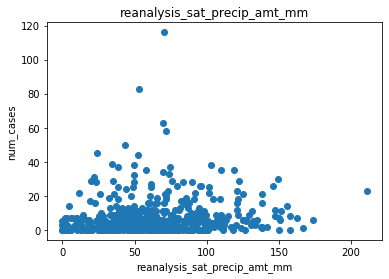

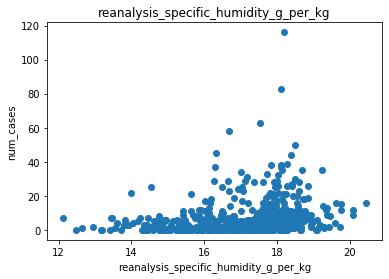

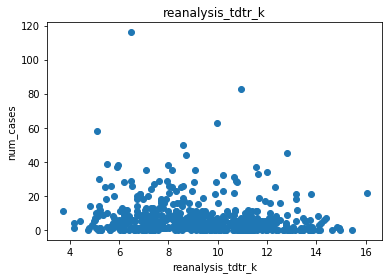

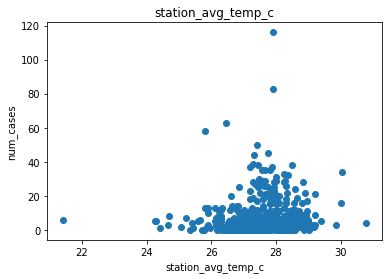

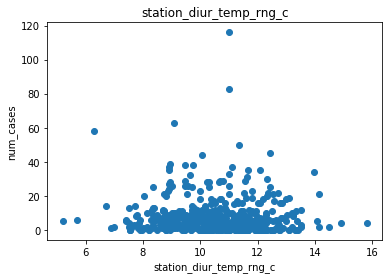

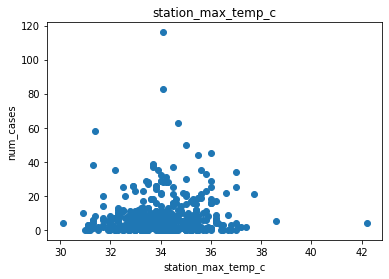

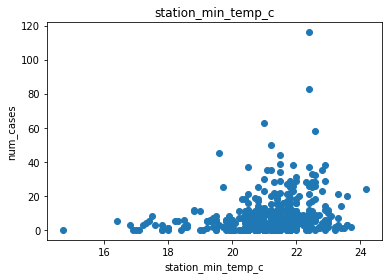

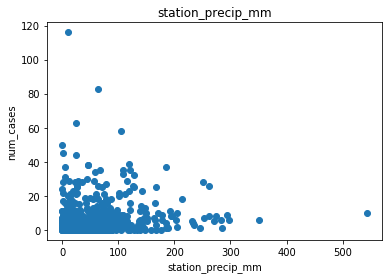

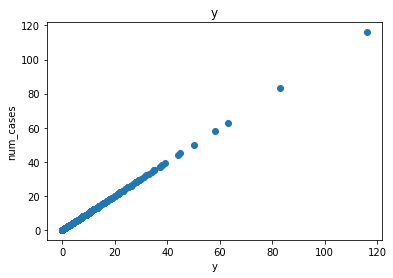

In [48]:
for col in iq.columns:
    if iq[col].dtype in ['float64','int64']:
        plt.scatter(iq[col],iq['y'])
        plt.title('{}'.format(col))
        plt.xlabel('{}'.format(col))
        plt.ylabel('num_cases')
        plt.show()

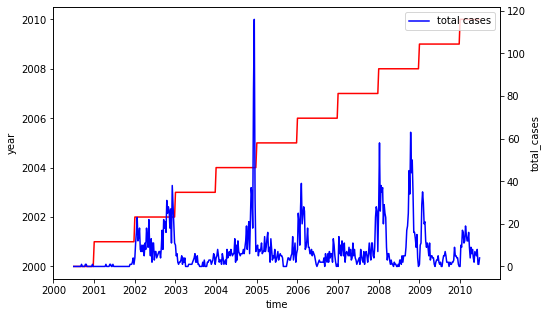

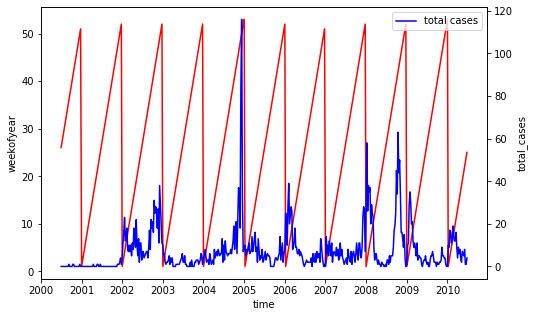

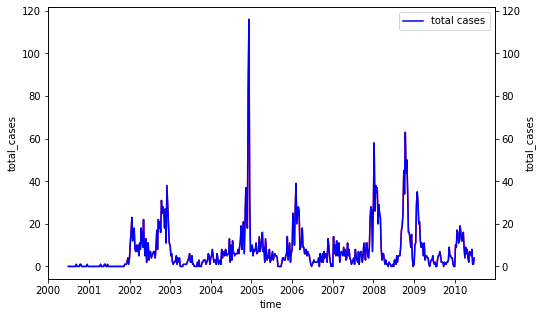

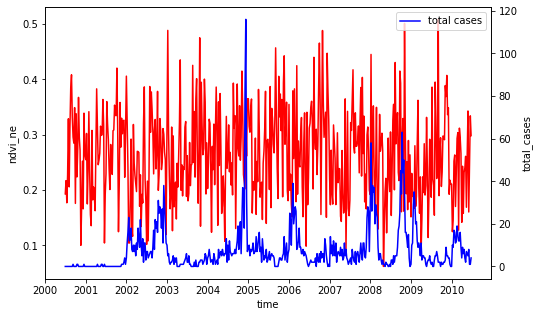

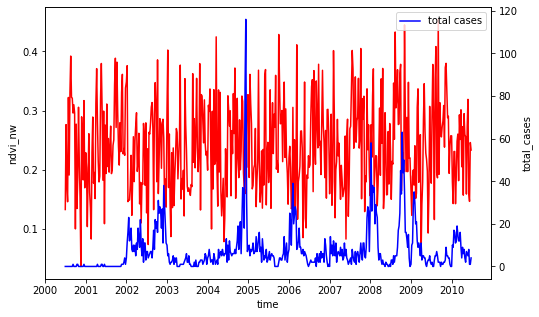

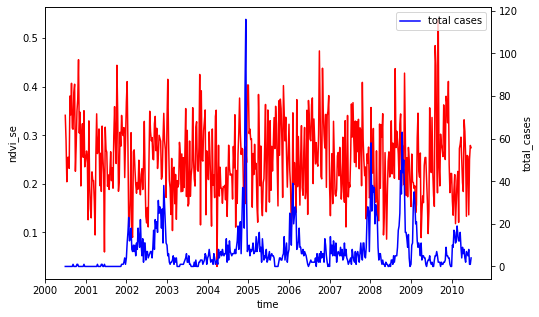

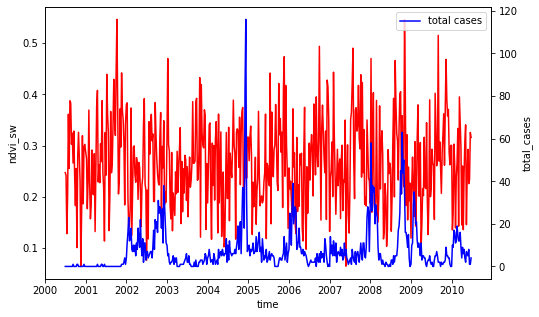

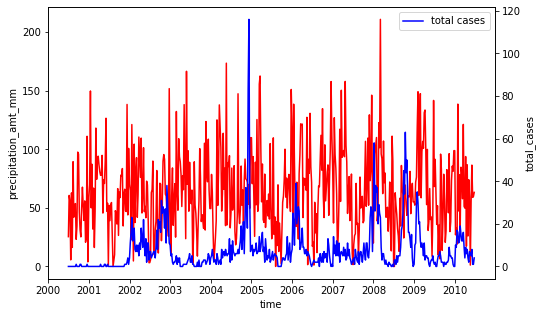

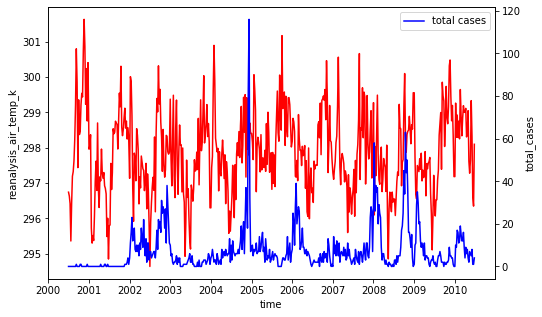

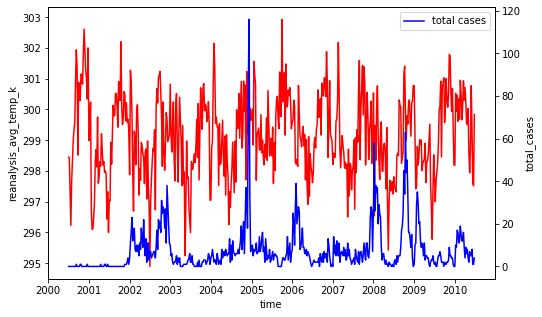

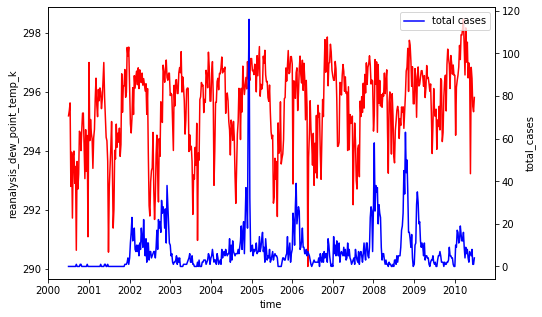

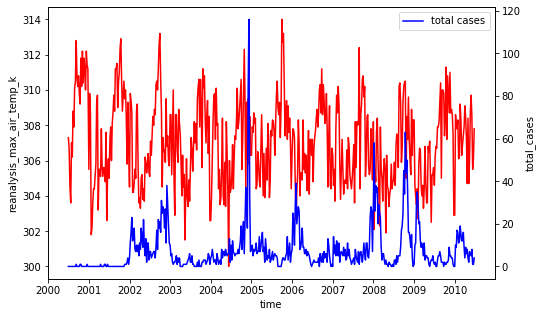

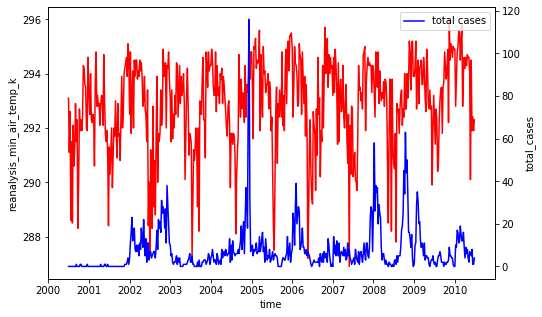

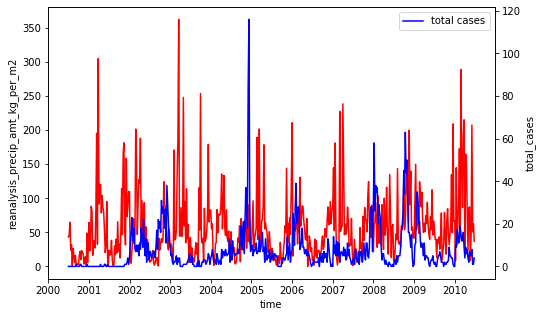

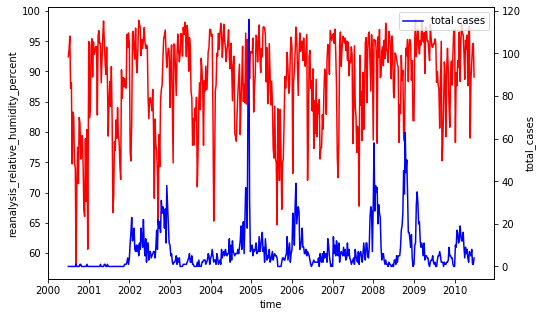

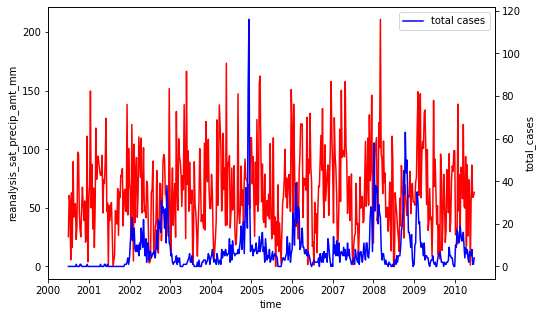

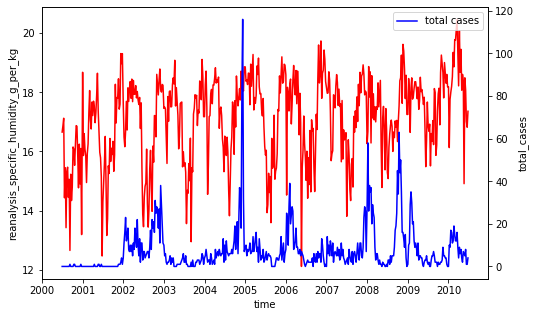

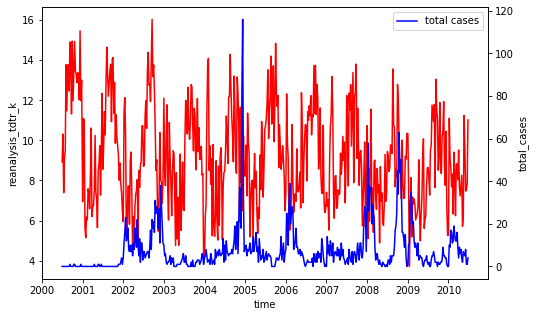

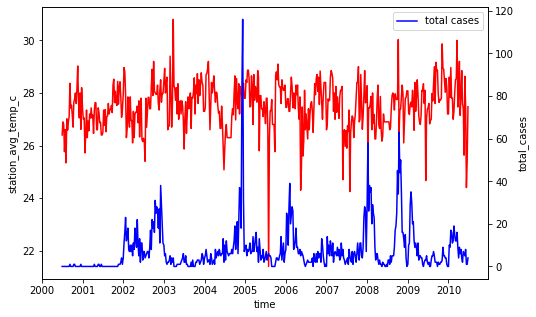

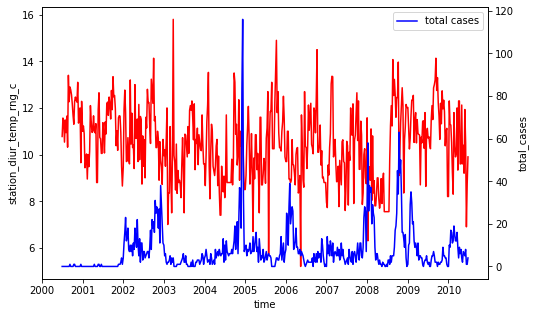

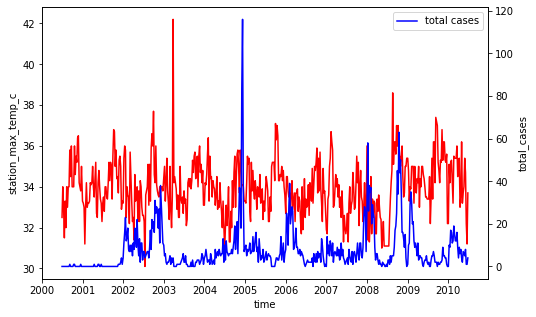

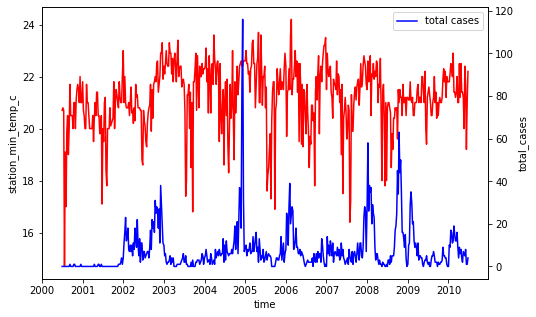

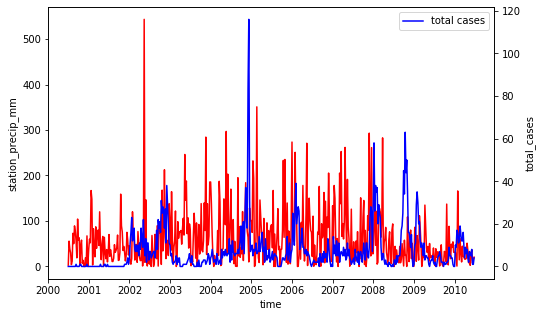

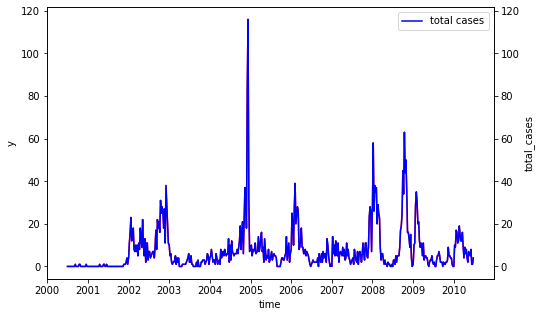

In [49]:
iq_plot = pd.DataFrame(iq.loc[iq.week_start_date.dt.year > 1990,:])
for col in iq.columns:
    if iq[col].dtype in ['float64','int64']:
        f, ax1 = plt.subplots(figsize=(8,5))
        ax1.plot(iq_plot['week_start_date'],iq_plot[col],label='{}'.format(col),c='r')
        ax1.set_xlabel('time')
        ax1.set_ylabel('{}'.format(col))
        ax2 = ax1.twinx()
        ax2.plot(iq_plot['week_start_date'],iq_plot['y'],label='total cases',c='b')
        ax2.set_ylabel('total_cases')
        plt.legend()
#         plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2008-05-01'))
        plt.show()

In [50]:
iq.columns


Index(['city', 'year', 'weekofyear', 'total_cases', 'week_start_date',
       'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'y'],
      dtype='object')

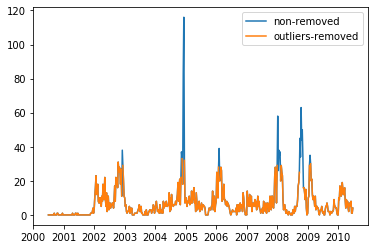

In [51]:
def remove_outliers_iq(y):
    iqr = pd.DataFrame(iq.y.describe()).T['75%'].values - pd.DataFrame(iq.y.describe()).T['25%'].values
    if y > (pd.DataFrame(iq.y.describe()).T['75%'].values + (3 * iqr)):
        return None
    else:
        return y
    
    
iq_testing = iq.copy()
iq_testing.y = iq_testing.y.apply(remove_outliers_iq)

plt.plot(iq['week_start_date'],iq['y'],label='non-removed')
plt.plot(iq_testing['week_start_date'],iq_testing['y'],label='outliers-removed')
plt.legend()
plt.show()

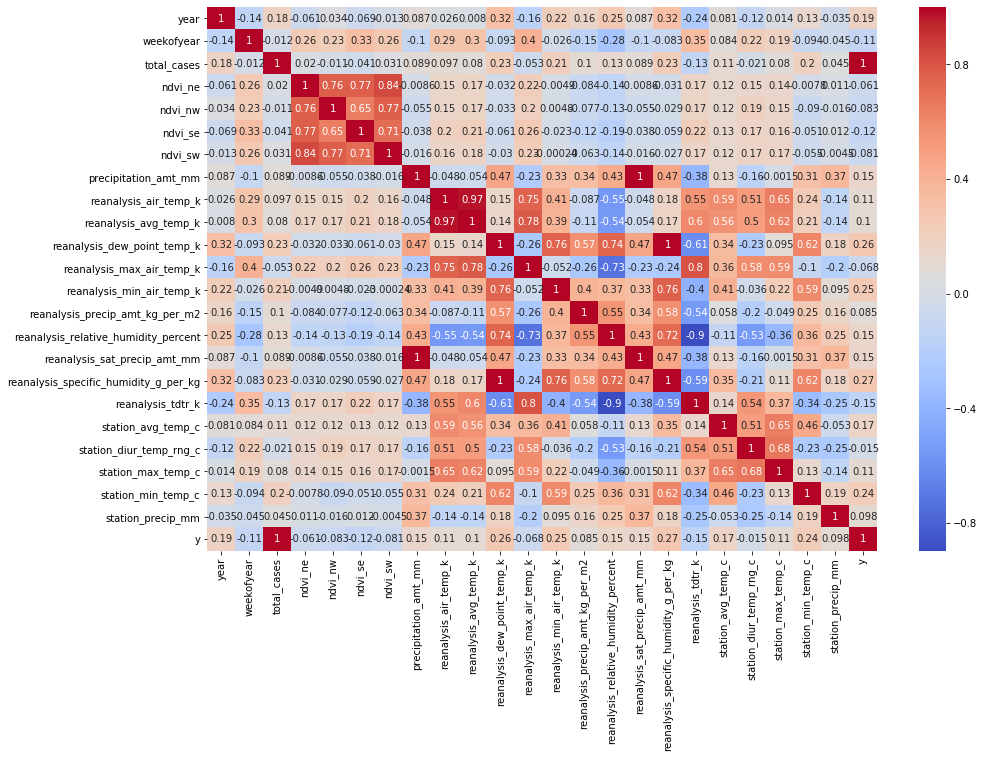

In [52]:
f, ax = plt.subplots(figsize=(15,10))
corr = iq_testing.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           ax=ax,
           annot=True,
           cmap="coolwarm")

In [53]:
# Can change between minmax and standard with following line, for testing 
scale = StandardScaler()
#add some more columns in to training data, tried not to overlap in category too much
# iq_train = pd.DataFrame(iq.loc[iq.week_start_date.dt.year > 2004,['week_start_date','y','station_precip_mm','ndvi_nw',
#                                  'ndvi_se','reanalysis_relative_humidity_percent','station_diur_temp_rng_c',
#                                               'reanalysis_avg_temp_k','station_min_temp_c','station_max_temp_c','reanalysis_min_air_temp_k',
#                                                                  'reanalysis_precip_amt_kg_per_m2','reanalysis_tdtr_k']])

iq_train = pd.DataFrame(iq_testing.loc[iq_testing.week_start_date.dt.year > 2004,['week_start_date','y','reanalysis_dew_point_temp_k',
                                                                 'reanalysis_min_air_temp_k','reanalysis_specific_humidity_g_per_kg',
                                                                 'reanalysis_tdtr_k']])
iq_train.rename(columns={'week_start_date':'ds'}, inplace=True)
# sj_train['cap'] = np.max(sj_train['y'])


iq_train_train = pd.DataFrame(iq_train.loc[iq_train.ds < pd.to_datetime('2009-06-01'),:])
print(iq_train_train.y.median(),iq_train_train.y.mean())
scale.fit(iq_train_train.y.values.reshape(-1,1))
iq_train_test = pd.DataFrame(iq_train.loc[iq_train.ds >= pd.to_datetime('2009-06-01'),:])
print(iq_train_test.y.median(),iq_train_test.y.mean())
iq_train_train.y = scale.transform(iq_train_train.y.values.reshape(-1,1))
iq_train_test.y = scale.transform(iq_train_test.y.values.reshape(-1,1))
#commented out cap lines are for growth='logistic'
# sj_train_test.cap = scale.transform(sj_train_test.cap.values.reshape(-1,1))
# sj_train_train.cap = scale.transform(sj_train_train.cap.values.reshape(-1,1))
iq_train_train.tail()



5.5 7.513761467889908
4.0 5.517857142857143


ds         y  reanalysis_dew_point_temp_k  \
1395 2009-04-30 -0.502331                   296.448571   
1396 2009-05-07 -0.502331                   296.484286   
1397 2009-05-14 -0.931215                   296.271429   
1398 2009-05-21 -1.074176                   296.012857   
1399 2009-05-28 -0.788254                   296.264286   

      reanalysis_min_air_temp_k  reanalysis_specific_humidity_g_per_kg  \
1395                      294.3                              18.018571   
1396                      292.9                              18.090000   
1397                      292.7                              17.858571   
1398                      293.4                              17.585714   
1399                      292.7                              17.830000   

      reanalysis_tdtr_k  
1395           6.271429  
1396           7.142857  
1397           9.071429  
1398          10.071429  
1399           5.614286

In [54]:
#add in regressors and tune parameters.  Fourier and prior scale have to do with how flexible the model is to changes
#higher number is model responds more strongly to that input, changepoint is on a smaller scale than seasonality and regressors
model = Prophet(changepoint_range=.65, growth='linear',yearly_seasonality=10, changepoint_prior_scale=.8,
               seasonality_prior_scale=8)
# model.add_seasonality(period=365*2,name='bi-anual',fourier_order=8, prior_scale=15)
model.add_regressor('reanalysis_dew_point_temp_k', mode='additive',prior_scale=8)
model.add_regressor('reanalysis_tdtr_k',standardize=True, mode='additive',prior_scale=10)
# model.add_regressor('ndvi_nw',standardize=True, mode='additive',prior_scale=10)
model.add_regressor('reanalysis_specific_humidity_g_per_kg',standardize=True, mode='additive',prior_scale=2)
# model.add_regressor('ndvi_se',standardize=True, mode='additive')
# model.add_regressor('reanalysis_relative_humidity_percent',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('reanalysis_min_air_temp_k',standardize=True, mode='additive',prior_scale=8)
# model.add_regressor('reanalysis_avg_temp_k',standardize=True, mode='additive',prior_scale=8)
# # model.add_regressor('station_min_temp_c',standardize=True, mode='additive',prior_scale=20)
# model.add_regressor('station_max_temp_c',standardize=True, mode='additive',prior_scale=8)
# model.add_regressor('reanalysis_min_air_temp_k',standardize=True, mode='additive',prior_scale=8)
# model.add_regressor('reanalysis_precip_amt_kg_per_m2',standardize=True, mode='additive',prior_scale=8)



model.fit(iq_train_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
future = model.make_future_dataframe(periods=52*1,freq='1W')
#furture dataframe needs the extra regressor columns, so in real world need to be able to also predict all of the 
#feature variables
#merge with existing one to get last year of data 
#fbprophet uses built in scaling again

iq_train_future = pd.DataFrame(iq.loc[iq.week_start_date.dt.year > 2004,['week_start_date','y','reanalysis_dew_point_temp_k',
                                                                 'reanalysis_min_air_temp_k','reanalysis_specific_humidity_g_per_kg',
                                                                 'reanalysis_tdtr_k']])
iq_train_future.rename(columns={'week_start_date':'ds'}, inplace=True)
iq_merge = iq_train_future.copy()

# iq_train_future = pd.DataFrame(iq_testing.loc[iq_testing.week_start_date.dt.year > 2004,['week_start_date','y','reanalysis_dew_point_temp_k',
#                                                                  'reanalysis_min_air_temp_k','reanalysis_specific_humidity_g_per_kg',
#                                                                  'reanalysis_tdtr_k']])
# iq_train_future.rename(columns={'week_start_date':'ds'}, inplace=True)
# iq_merge = pd.DataFrame(iq_train_future.loc[:,['ds','reanalysis_dew_point_temp_k',
#                                                                  'reanalysis_min_air_temp_k','reanalysis_specific_humidity_g_per_kg',
#                                                                  'reanalysis_tdtr_k']])

future_n = pd.merge(iq_merge.set_index(pd.DatetimeIndex(iq_merge['ds'])), 
                    future.set_index(pd.DatetimeIndex(future['ds'])), 
                    how='left', left_index=True, right_index=True)
future_n = future_n.reset_index()
future_n.drop(columns=['ds_x','ds_y'], inplace=True)
# future_n.cap = scale.transform(future_n.cap.values.reshape(-1,1))
future_n.tail()

ds  y  reanalysis_dew_point_temp_k  reanalysis_min_air_temp_k  \
281 2010-05-28  5                   296.825714                      294.5   
282 2010-06-04  8                   296.452857                      291.9   
283 2010-06-11  1                   295.501429                      292.4   
284 2010-06-18  1                   295.324286                      291.9   
285 2010-06-25  4                   295.807143                      292.3   

     reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  
281                              18.485714           9.800000  
282                              18.070000           7.471429  
283                              17.008571           7.500000  
284                              16.815714           7.871429  
285                              17.355714          11.014286

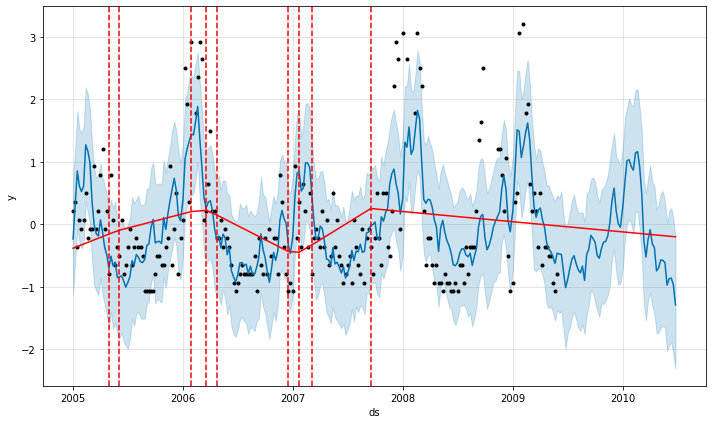

In [56]:
forcast = model.predict(future_n)
fig = model.plot(forcast)
a = add_changepoints_to_plot(fig.gca(), model, forcast)

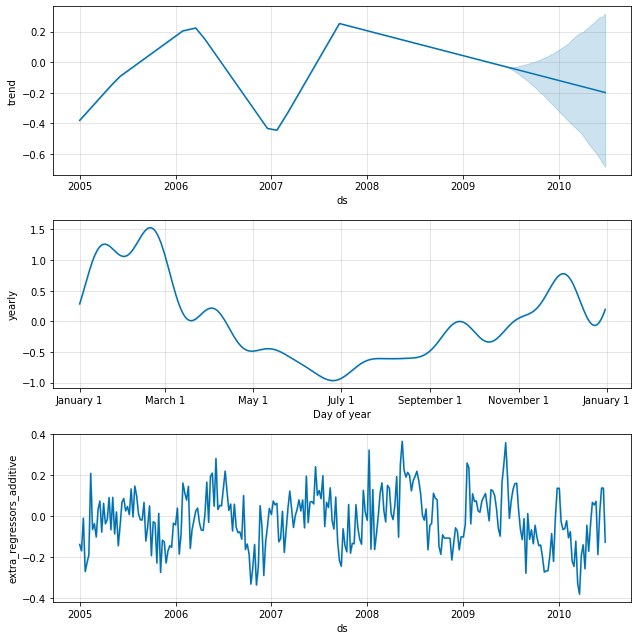

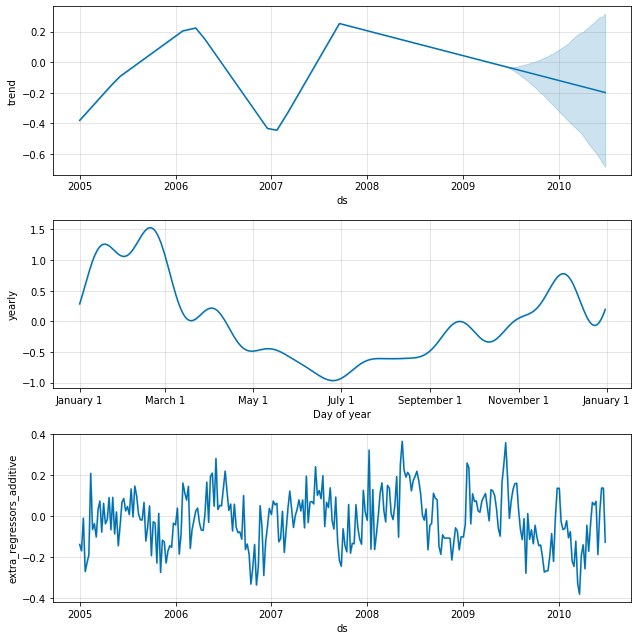

In [57]:
model.plot_components(forcast)

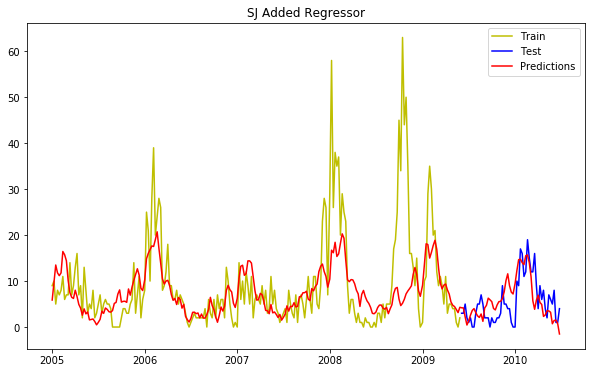

In [58]:
iq_train_train = pd.DataFrame(iq_train_future.loc[iq_train_future.ds < pd.to_datetime('2009-06-01'),:])

iq_train_test = pd.DataFrame(iq_train_future.loc[iq_train_future.ds >= pd.to_datetime('2009-06-01'),:])

#vis results
plt.figure(figsize=(10,6))
plt.plot(iq_train_train['ds'], 
            iq_train_train['y'], c='y',label="Train")
plt.plot(iq_train_test['ds'],
            iq_train_test['y'],c='b',label="Test")
plt.plot(forcast['ds'],
            scale.inverse_transform(forcast['yhat'].values.reshape(-1,1)),c='r',label="Predictions")

plt.legend()
plt.title('SJ Added Regressor')
plt.show()

Train R2 0.25858071922345127
Test R2 0.25101648818394007
Train MAE 5.292773797896206
Test MAE 3.452734675920218


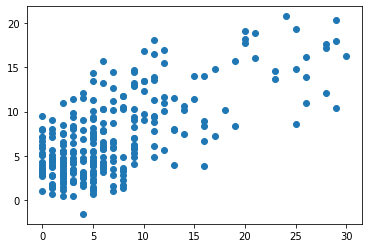

In [59]:
plt.scatter(iq_train['y'],scale.inverse_transform(forcast['yhat'].values.reshape(-1,1)))
print('Train R2',r2_score(iq_train_train['y'],scale.inverse_transform(forcast.loc[forcast.ds < pd.to_datetime('2009-06-01'), 'yhat'].values.reshape(-1,1)).reshape(len(iq_train_train),)))
print('Test R2',r2_score(iq_train_test['y'],scale.inverse_transform(forcast.loc[forcast.ds >= pd.to_datetime('2009-06-01'), 'yhat'].values.reshape(-1,1)).reshape(len(iq_train_test),)))
print('Train MAE',mean_absolute_error(iq_train_train['y'],scale.inverse_transform(forcast.loc[forcast.ds < pd.to_datetime('2009-06-01'), 'yhat'].values.reshape(-1,1)).reshape(len(iq_train_train),)))
print('Test MAE',mean_absolute_error(iq_train_test['y'],scale.inverse_transform(forcast.loc[forcast.ds >= pd.to_datetime('2009-06-01'), 'yhat'].values.reshape(-1,1)).reshape(len(iq_train_test),)))

In [60]:
train = pd.DataFrame(iq_train_train.loc[:,['ds','y']])
test = pd.DataFrame(iq_train_test.loc[:,['ds','y']])
# train.y = scale.inverse_transform(train.y)
# test.y = scale.inverse_transform(test.y)
predictions = pd.DataFrame(forcast.loc[:,['ds','yhat']])
predictions.yhat = scale.inverse_transform(predictions.yhat)
predictions.yhat = predictions.yhat.apply(fill_0)
train.y = train.y.astype(int)
test.y = test.y.astype(int)
train.to_csv('iq_train.csv',date_format='%Y-%m-%d',index=False)
test.to_csv('iq_test.csv',date_format='%Y-%m-%d',index=False)
predictions.to_csv('iq_predictions.csv',date_format='%Y-%m-%d',index=False)


In [61]:
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon = '730 days')
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2006-06-03 00:00:00 and 2007-05-29 00:00:00


ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2006-06-04 -0.451048   -1.085082    0.204319 -0.359370 2006-06-03
1 2006-06-11 -0.812850   -1.461247   -0.131445 -0.645293 2006-06-03
2 2006-06-18 -0.851028   -1.537276   -0.192185 -0.931215 2006-06-03
3 2006-06-25 -0.967686   -1.611754   -0.291217 -1.074176 2006-06-03
4 2006-07-02 -0.974571   -1.661848   -0.272841 -0.931215 2006-06-03

horizon       mse      rmse       mae      mape  coverage
0 64 days  1.026444  1.013136  0.763715  2.172836  0.571429
1 67 days  1.084310  1.041302  0.806019  2.234790  0.535714
2 69 days  1.087877  1.043014  0.808995  2.214847  0.535714
3 71 days  1.100572  1.049081  0.819673  2.216919  0.500000
4 74 days  1.272052  1.127853  0.892175  2.577037  0.464286

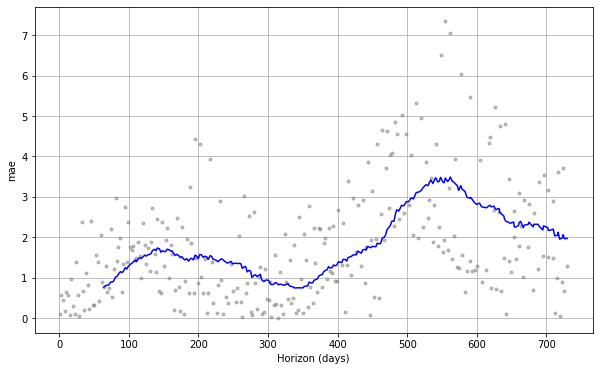

In [62]:
df_p = performance_metrics(df_cv)
display(df_p.head())

fig = plot_cross_validation_metric(df_cv, metric='mae')

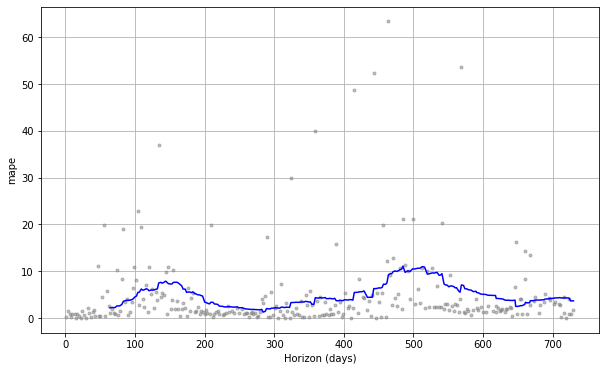

In [63]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

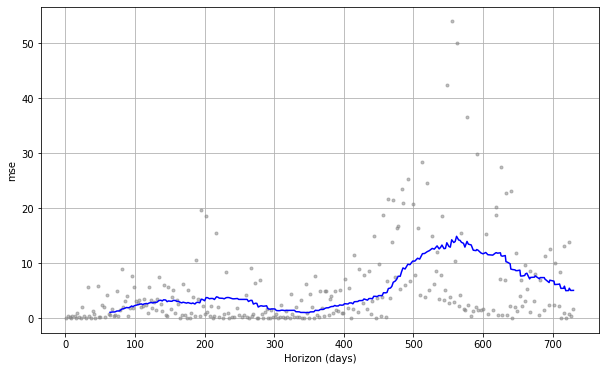

In [64]:
fig = plot_cross_validation_metric(df_cv, metric='mse')

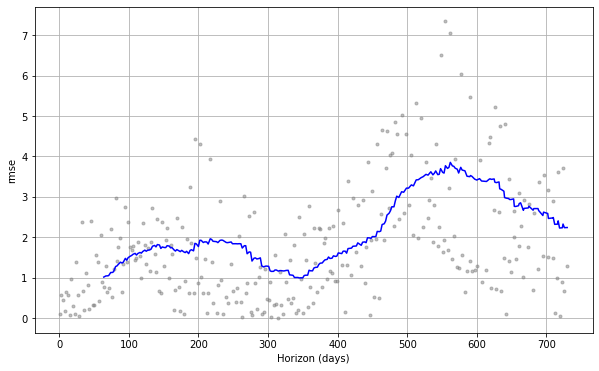

In [65]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

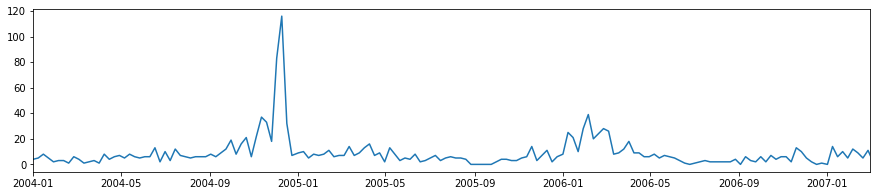

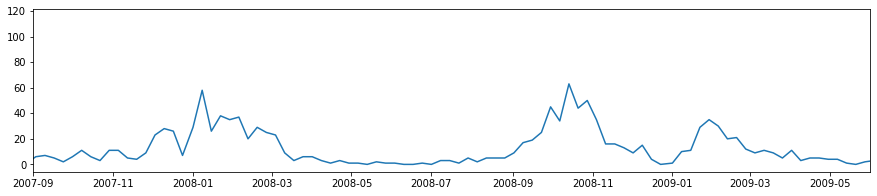

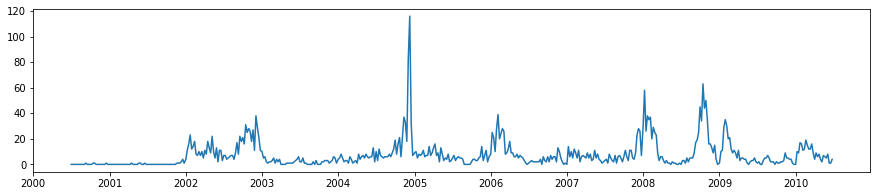

In [66]:
plt.figure(figsize=(15,3))
plt.plot(iq['week_start_date'],iq['y'])
plt.xlim(pd.to_datetime('2004-01-01'), pd.to_datetime('2007-03-01'))
plt.show()
plt.figure(figsize=(15,3))
plt.plot(iq['week_start_date'],iq['y'])
plt.xlim(pd.to_datetime('2007-09-01'), pd.to_datetime('2009-06-01'))
plt.show()
plt.figure(figsize=(15,3))
plt.plot(iq['week_start_date'],iq['y'])
plt.show()

## Now predicting out the four years for competition, can't measure accuracy here because only given training features

In [67]:
comp_test = pd.read_csv('DengAI_Predicting_Disease_Spread_-_Test_Data_Features.csv')
comp_test['week_start_date'] = pd.to_datetime(comp_test['week_start_date'])

comp_test.tail()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
411   iq  2013          22      2013-05-28  0.301471  0.380029  0.280629   
412   iq  2013          23      2013-06-04  0.247600  0.296343  0.285371   
413   iq  2013          24      2013-06-11  0.238729  0.251029  0.252586   
414   iq  2013          25      2013-06-18  0.310429  0.302700  0.406614   
415   iq  2013          26      2013-06-25  0.339467  0.240071  0.356943   

      ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
411  0.383186                 41.12             297.774286  ...   
412  0.350357                 71.52             297.167143  ...   
413  0.249771                 78.96             295.831429  ...   
414  0.403943                 39.54             295.778571  ...   
415  0.273600                 51.80             297.372857  ...   

     reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
411                            67.60                             89.990000   
412                            45.70                             93.891429   
413                            45.22                             94.967143   
414                             4.70                             89.057143   
415                            27.80                             87.030000   

     reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
411                         41.12                              17.185714   
412                         71.52                              17.448571   
413                         78.96                              16.410000   
414                         39.54                              15.137143   
415                         51.80                              16.148571   

     reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
411          10.100000               27.40                    9.050   
412           9.657143               27.52                   10.720   
413           7.385714               27.20                   10.075   
414           8.228571               26.70                    8.480   
415          11.542857               27.35                    9.675   

     station_max_temp_c  station_min_temp_c  station_precip_mm  
411                32.6                21.8               33.0  
412                33.8                21.4               68.0  
413                32.6                21.6               93.2  
414                32.2                21.8               34.1  
415                32.6                22.0               14.9  

[5 rows x 24 columns]

In [68]:
sj_comp = pd.DataFrame(comp_test.loc[comp_test.city == 'sj'])
iq_comp = pd.DataFrame(comp_test.loc[comp_test.city == 'iq'])
# fill the null values
# fills with last observation (takes last weeks data) 'ffil' -> forward fill
sj_comp.fillna(method='ffill',inplace=True)
iq_comp.fillna(method='ffill',inplace=True)
print(sj_comp.info())
print(iq_comp.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 24 columns):
city                                     260 non-null object
year                                     260 non-null int64
weekofyear                               260 non-null int64
week_start_date                          260 non-null datetime64[ns]
ndvi_ne                                  260 non-null float64
ndvi_nw                                  260 non-null float64
ndvi_se                                  260 non-null float64
ndvi_sw                                  260 non-null float64
precipitation_amt_mm                     260 non-null float64
reanalysis_air_temp_k                    260 non-null float64
reanalysis_avg_temp_k                    260 non-null float64
reanalysis_dew_point_temp_k              260 non-null float64
reanalysis_max_air_temp_k                260 non-null float64
reanalysis_min_air_temp_k                260 non-null float64
reanalysis_precip_amt_kg_

In [69]:
scale_sj = StandardScaler()
sj_train = pd.DataFrame(sj.loc[sj.week_start_date.dt.year > 1999,['week_start_date','y','station_precip_mm','ndvi_ne',
                                 'ndvi_sw','reanalysis_relative_humidity_percent','station_diur_temp_rng_c',
                                              'reanalysis_avg_temp_k','station_min_temp_c','station_max_temp_c','reanalysis_dew_point_temp_k',
                                                                 'reanalysis_precip_amt_kg_per_m2']])
sj_train.rename(columns={'week_start_date':'ds'}, inplace=True)




scale_sj.fit(sj_train.y.values.reshape(-1,1))
sj_train.y = scale_sj.transform(sj_train.y.values.reshape(-1,1))

#commented out cap lines are for growth='logistic'
# sj_train_test.cap = scale.transform(sj_train_test.cap.values.reshape(-1,1))
# sj_train_train.cap = scale.transform(sj_train_train.cap.values.reshape(-1,1))
sj_train.head()



ds         y  station_precip_mm  ndvi_ne   ndvi_sw  \
503 2000-01-01 -0.100082                7.9 -0.13360  0.086311   
504 2000-01-08 -0.141952               28.6  0.20635  0.095833   
505 2000-01-15  0.151138               12.0  0.33700  0.168629   
506 2000-01-22 -0.058212               17.7  0.35300  0.291429   
507 2000-01-29 -0.058212                2.0  0.34190  0.381420   

     reanalysis_relative_humidity_percent  station_diur_temp_rng_c  \
503                             76.317143                 6.557143   
504                             79.607143                 5.314286   
505                             77.342857                 5.157143   
506                             70.457143                 4.828571   
507                             67.765714                 6.842857   

     reanalysis_avg_temp_k  station_min_temp_c  station_max_temp_c  \
503             298.307143                21.1                29.4   
504             298.164286                21.7                29.4   
505             297.585714                21.7                28.3   
506             296.478571                20.0                27.2   
507             296.364286                17.8                28.3   

     reanalysis_dew_point_temp_k  reanalysis_precip_amt_kg_per_m2  
503                   293.887143                            12.34  
504                   294.355714                            32.30  
505                   293.191429                            47.10  
506                   290.852857                            14.70  
507                   289.827143                             0.70

In [70]:
model = Prophet(changepoint_range=.75, growth='linear',yearly_seasonality=False, changepoint_prior_scale=.8)
model.add_seasonality(period=365*2,name='bi-anual',fourier_order=10, prior_scale=6)
model.add_regressor('station_precip_mm', mode='additive',prior_scale=8)
model.add_regressor('ndvi_ne',standardize=True, mode='additive',prior_scale=2)
# model.add_regressor('ndvi_nw',standardize=True, mode='additive',prior_scale=10)
model.add_regressor('ndvi_sw',standardize=True, mode='additive',prior_scale=2)
# model.add_regressor('ndvi_se',standardize=True, mode='additive')
model.add_regressor('reanalysis_relative_humidity_percent',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('station_diur_temp_rng_c',standardize=True, mode='additive',prior_scale=10)
model.add_regressor('reanalysis_avg_temp_k',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('station_min_temp_c',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('station_max_temp_c',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('reanalysis_dew_point_temp_k',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('reanalysis_precip_amt_kg_per_m2',standardize=True, mode='additive',prior_scale=10)



model.fit(sj_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
future = model.make_future_dataframe(periods=52*6,freq='1W')
sj_comp.rename(columns={'week_start_date':'ds'}, inplace=True)
sj_full_train = pd.concat([sj_train,pd.DataFrame(sj_comp.loc[:,['ds','station_precip_mm','ndvi_ne',
                                 'ndvi_sw','reanalysis_relative_humidity_percent','station_diur_temp_rng_c',
                                              'reanalysis_avg_temp_k','station_min_temp_c','station_max_temp_c','reanalysis_dew_point_temp_k',
                                                                 'reanalysis_precip_amt_kg_per_m2']])])
sj_merge = pd.DataFrame(sj_full_train.loc[:,['ds','station_precip_mm','ndvi_ne',
                                 'ndvi_sw','reanalysis_relative_humidity_percent','station_diur_temp_rng_c',
                                              'reanalysis_avg_temp_k','station_min_temp_c','station_max_temp_c','reanalysis_dew_point_temp_k',
                                       'reanalysis_precip_amt_kg_per_m2']])

future_n = pd.merge(sj_merge.set_index(pd.DatetimeIndex(sj_merge['ds'])), 
                    future.set_index(pd.DatetimeIndex(future['ds'])), 
                    how='left', left_index=True, right_index=True)
future_n = future_n.reset_index()
future_n.drop(columns=['ds_x','ds_y'], inplace=True)
# future_n.cap = scale.transform(future_n.cap.values.reshape(-1,1))
display(future_n.head())
future_n.tail()

C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




ds  station_precip_mm  ndvi_ne   ndvi_sw  \
0 2000-01-01                7.9 -0.13360  0.086311   
1 2000-01-08               28.6  0.20635  0.095833   
2 2000-01-15               12.0  0.33700  0.168629   
3 2000-01-22               17.7  0.35300  0.291429   
4 2000-01-29                2.0  0.34190  0.381420   

   reanalysis_relative_humidity_percent  station_diur_temp_rng_c  \
0                             76.317143                 6.557143   
1                             79.607143                 5.314286   
2                             77.342857                 5.157143   
3                             70.457143                 4.828571   
4                             67.765714                 6.842857   

   reanalysis_avg_temp_k  station_min_temp_c  station_max_temp_c  \
0             298.307143                21.1                29.4   
1             298.164286                21.7                29.4   
2             297.585714                21.7                28.3   
3             296.478571                20.0                27.2   
4             296.364286                17.8                28.3   

   reanalysis_dew_point_temp_k  reanalysis_precip_amt_kg_per_m2  
0                   293.887143                            12.34  
1                   294.355714                            32.30  
2                   293.191429                            47.10  
3                   290.852857                            14.70  
4                   289.827143                             0.70

ds  station_precip_mm  ndvi_ne   ndvi_sw  \
688 2013-03-26                3.5 -0.08740  0.105186   
689 2013-04-02               17.6 -0.20325  0.178914   
690 2013-04-09                9.4 -0.11760  0.170429   
691 2013-04-16               22.9  0.08275  0.074857   
692 2013-04-23               47.5 -0.08730  0.117671   

     reanalysis_relative_humidity_percent  station_diur_temp_rng_c  \
688                             78.780000                 7.942857   
689                             81.650000                 6.642857   
690                             78.285714                 8.114286   
691                             77.674286                 6.942857   
692                             79.045714                 6.742857   

     reanalysis_avg_temp_k  station_min_temp_c  station_max_temp_c  \
688             298.885714                22.8                33.9   
689             298.157143                22.8                33.3   
690             299.328571                23.3                32.8   
691             299.064286                23.9                31.7   
692             298.042857                21.7                31.1   

     reanalysis_dew_point_temp_k  reanalysis_precip_amt_kg_per_m2  
688                   294.675714                             2.55  
689                   294.628571                            64.30  
690                   294.948571                             0.70  
691                   294.678571                             1.40  
692                   294.132857                            19.90

In [72]:
forcast_sj_comp = model.predict(future_n)
forcast_sj_comp.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2000-01-01  0.076877   -0.576212    0.569619     0.076877     0.076877   
1 2000-01-08  0.080494   -0.650982    0.476705     0.080494     0.080494   
2 2000-01-15  0.084112   -0.796348    0.281464     0.084112     0.084112   
3 2000-01-22  0.087729   -0.793351    0.295172     0.087729     0.087729   
4 2000-01-29  0.091347   -0.847300    0.275729     0.091347     0.091347   

   additive_terms  additive_terms_lower  additive_terms_upper  bi-anual  ...  \
0       -0.078444             -0.078444             -0.078444 -0.179207  ...   
1       -0.191308             -0.191308             -0.191308 -0.212251  ...   
2       -0.352275             -0.352275             -0.352275 -0.237237  ...   
3       -0.325841             -0.325841             -0.325841 -0.271147  ...   
4       -0.372284             -0.372284             -0.372284 -0.325629  ...   

   station_min_temp_c  station_min_temp_c_lower  station_min_temp_c_upper  \
0            0.106951                  0.106951                  0.106951   
1            0.063885                  0.063885                  0.063885   
2            0.063885                  0.063885                  0.063885   
3            0.185904                  0.185904                  0.185904   
4            0.343811                  0.343811                  0.343811   

   station_precip_mm  station_precip_mm_lower  station_precip_mm_upper  \
0           0.005480                 0.005480                 0.005480   
1          -0.000138                -0.000138                -0.000138   
2           0.004367                 0.004367                 0.004367   
3           0.002821                 0.002821                 0.002821   
4           0.007081                 0.007081                 0.007081   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0 -0.001567  
1                         0.0 -0.110814  
2                         0.0 -0.268163  
3                         0.0 -0.238112  
4                         0.0 -0.280937  

[5 rows x 49 columns]

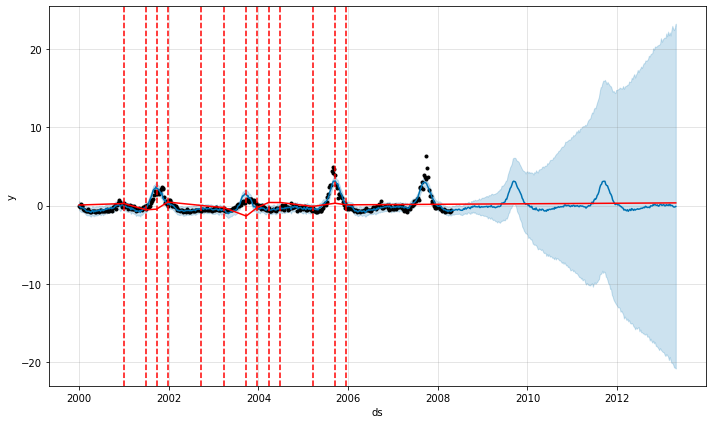

In [73]:
fig = model.plot(forcast_sj_comp)
a = add_changepoints_to_plot(fig.gca(), model, forcast_sj_comp)

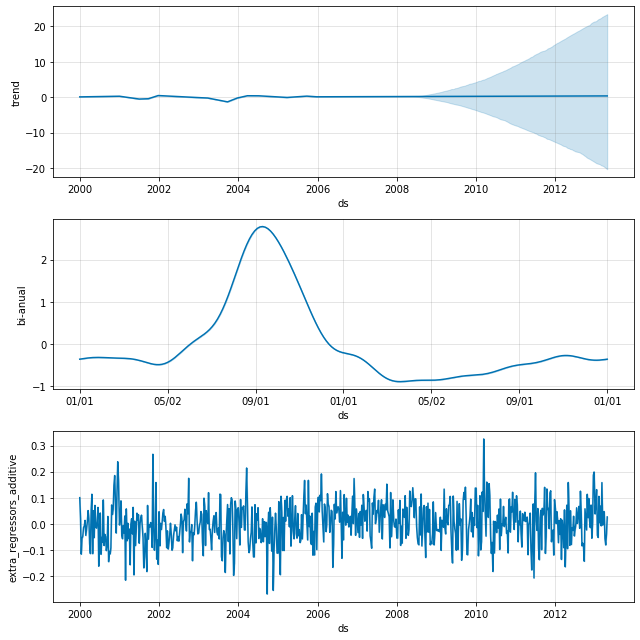

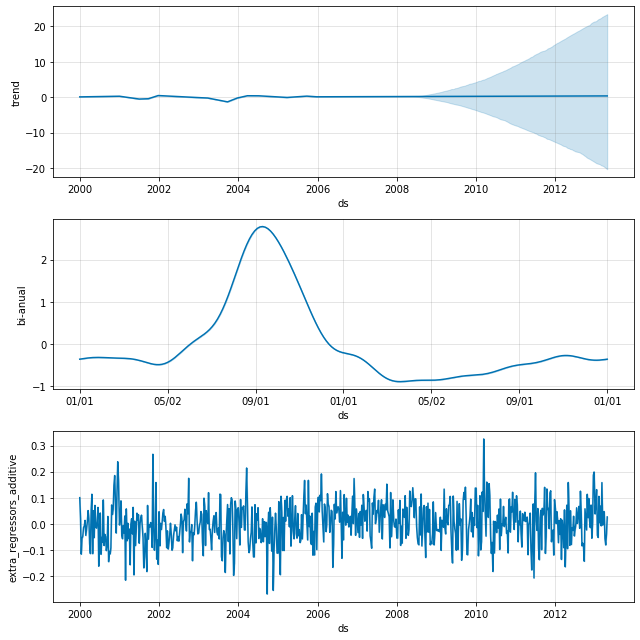

In [74]:

model.plot_components(forcast_sj_comp)

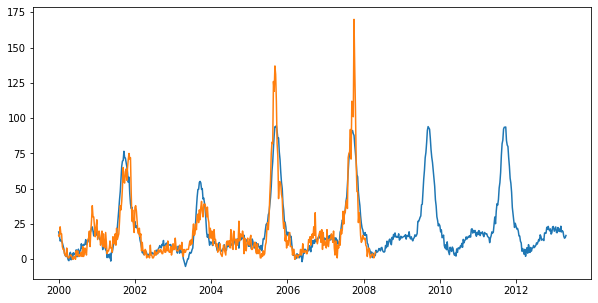

In [75]:
plt.figure(figsize=(10,5))
plt.plot(forcast_sj_comp['ds'], scale_sj.inverse_transform(forcast_sj_comp.yhat.values),label='Predictions')
plt.plot(sj.loc[sj.week_start_date.dt.year > 1999,'week_start_date'].values, sj.loc[sj.week_start_date.dt.year > 1999,'y'].values,
        label='Training Values')
plt.show()

In [76]:
scale_iq = StandardScaler()
#add some more columns in to training data, tried not to overlap in category too much
# iq_train = pd.DataFrame(iq.loc[iq.week_start_date.dt.year > 2004,['week_start_date','y','station_precip_mm','ndvi_nw',
#                                  'ndvi_se','reanalysis_relative_humidity_percent','station_diur_temp_rng_c',
#                                               'reanalysis_avg_temp_k','station_min_temp_c','station_max_temp_c','reanalysis_min_air_temp_k',
#                                                                  'reanalysis_precip_amt_kg_per_m2','reanalysis_tdtr_k']])

iq_train = pd.DataFrame(iq_testing.loc[iq_testing.week_start_date.dt.year > 2004,['week_start_date','y','reanalysis_dew_point_temp_k',
                                                                 'reanalysis_min_air_temp_k','reanalysis_specific_humidity_g_per_kg',
                                                                 'reanalysis_tdtr_k']])
iq_train.rename(columns={'week_start_date':'ds'}, inplace=True)
# sj_train['cap'] = np.max(sj_train['y'])



scale_iq.fit(iq_train.y.values.reshape(-1,1))

iq_train.y = scale_iq.transform(iq_train.y.values.reshape(-1,1))

#commented out cap lines are for growth='logistic'
# sj_train_test.cap = scale.transform(sj_train_test.cap.values.reshape(-1,1))
# sj_train_train.cap = scale.transform(sj_train_train.cap.values.reshape(-1,1))
iq_train.head()

ds         y  reanalysis_dew_point_temp_k  \
1170 2005-01-01  0.284637                   297.122857   
1171 2005-01-08  0.434908                   296.712857   
1172 2005-01-15 -0.316446                   296.727143   
1173 2005-01-22  0.134366                   296.580000   
1174 2005-01-29 -0.015905                   296.931429   

      reanalysis_min_air_temp_k  reanalysis_specific_humidity_g_per_kg  \
1170                      294.8                              18.855714   
1171                      293.5                              18.370000   
1172                      291.6                              18.408571   
1173                      295.0                              18.258571   
1174                      294.9                              18.645714   

      reanalysis_tdtr_k  
1170           8.228571  
1171           9.757143  
1172           7.228571  
1173          11.357143  
1174           9.985714

In [77]:
model = Prophet(changepoint_range=.8, growth='linear',yearly_seasonality=10, changepoint_prior_scale=.8,
               seasonality_prior_scale=8)
# model.add_seasonality(period=365*2,name='bi-anual',fourier_order=8, prior_scale=15)
model.add_regressor('reanalysis_dew_point_temp_k', mode='additive',prior_scale=8)
model.add_regressor('reanalysis_tdtr_k',standardize=True, mode='additive',prior_scale=10)
# model.add_regressor('ndvi_nw',standardize=True, mode='additive',prior_scale=10)
model.add_regressor('reanalysis_specific_humidity_g_per_kg',standardize=True, mode='additive',prior_scale=2)
# model.add_regressor('ndvi_se',standardize=True, mode='additive')
# model.add_regressor('reanalysis_relative_humidity_percent',standardize=True, mode='additive',prior_scale=8)
model.add_regressor('reanalysis_min_air_temp_k',standardize=True, mode='additive',prior_scale=8)
# model.add_regressor('reanalysis_avg_temp_k',standardize=True, mode='additive',prior_scale=8)
# # model.add_regressor('station_min_temp_c',standardize=True, mode='additive',prior_scale=20)
# model.add_regressor('station_max_temp_c',standardize=True, mode='additive',prior_scale=8)
# model.add_regressor('reanalysis_min_air_temp_k',standardize=True, mode='additive',prior_scale=8)
# model.add_regressor('reanalysis_precip_amt_kg_per_m2',standardize=True, mode='additive',prior_scale=8)



model.fit(iq_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
future = model.make_future_dataframe(periods=52*6,freq='1W')
iq_comp.rename(columns={'week_start_date':'ds'}, inplace=True)
iq_full_train = pd.concat([iq_train,pd.DataFrame(iq_comp.loc[:,['ds','reanalysis_dew_point_temp_k',
                                                                 'reanalysis_min_air_temp_k','reanalysis_specific_humidity_g_per_kg',
                                                                 'reanalysis_tdtr_k']])])



iq_merge = iq_full_train.copy()



future_iq = pd.merge(iq_merge.set_index(pd.DatetimeIndex(iq_merge['ds'])), 
                    future.set_index(pd.DatetimeIndex(future['ds'])), 
                    how='left', left_index=True, right_index=True)
future_iq = future_iq.reset_index()
future_iq.drop(columns=['ds_x','ds_y'], inplace=True)
# future_n.cap = scale.transform(future_n.cap.values.reshape(-1,1))
display(future_iq.head())
future_iq.tail()

C:\Users\graha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




ds  reanalysis_dew_point_temp_k  reanalysis_min_air_temp_k  \
0 2005-01-01                   297.122857                      294.8   
1 2005-01-08                   296.712857                      293.5   
2 2005-01-15                   296.727143                      291.6   
3 2005-01-22                   296.580000                      295.0   
4 2005-01-29                   296.931429                      294.9   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k         y  
0                              18.855714           8.228571  0.284637  
1                              18.370000           9.757143  0.434908  
2                              18.408571           7.228571 -0.316446  
3                              18.258571          11.357143  0.134366  
4                              18.645714           9.985714 -0.015905

ds  reanalysis_dew_point_temp_k  reanalysis_min_air_temp_k  \
437 2013-05-28                   295.638571                      292.7   
438 2013-06-04                   295.845714                      291.6   
439 2013-06-11                   294.894286                      290.7   
440 2013-06-18                   293.648571                      292.5   
441 2013-06-25                   294.615714                      289.6   

     reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k   y  
437                              17.185714          10.100000 NaN  
438                              17.448571           9.657143 NaN  
439                              16.410000           7.385714 NaN  
440                              15.137143           8.228571 NaN  
441                              16.148571          11.542857 NaN

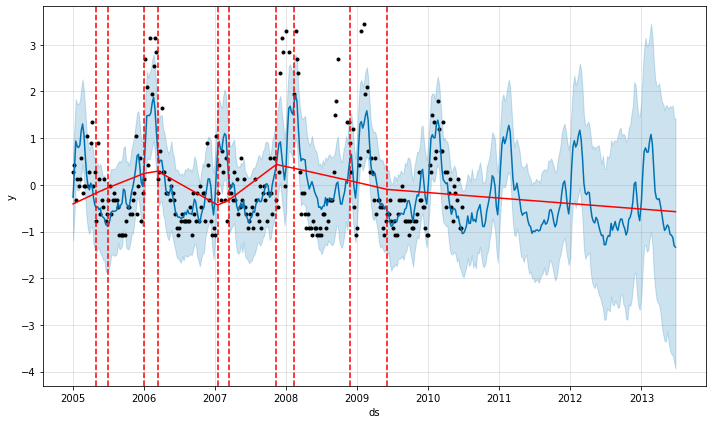

In [79]:
forcast_iq_comp = model.predict(future_iq)
fig = model.plot(forcast_iq_comp)
a = add_changepoints_to_plot(fig.gca(), model, forcast_iq_comp)

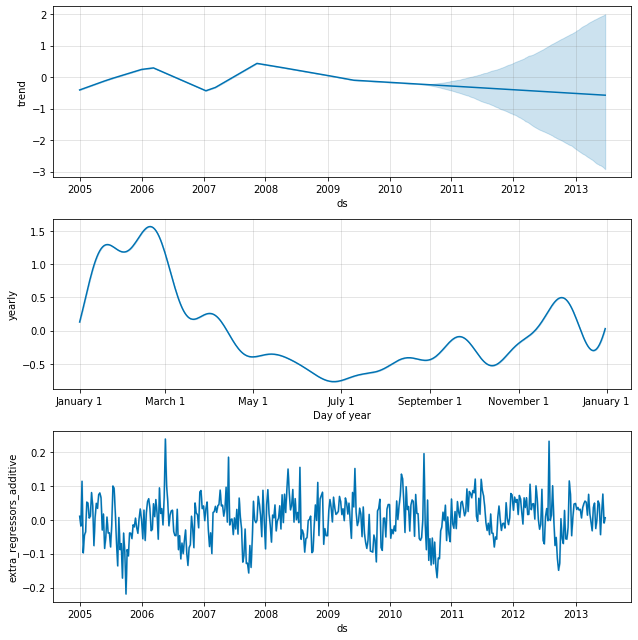

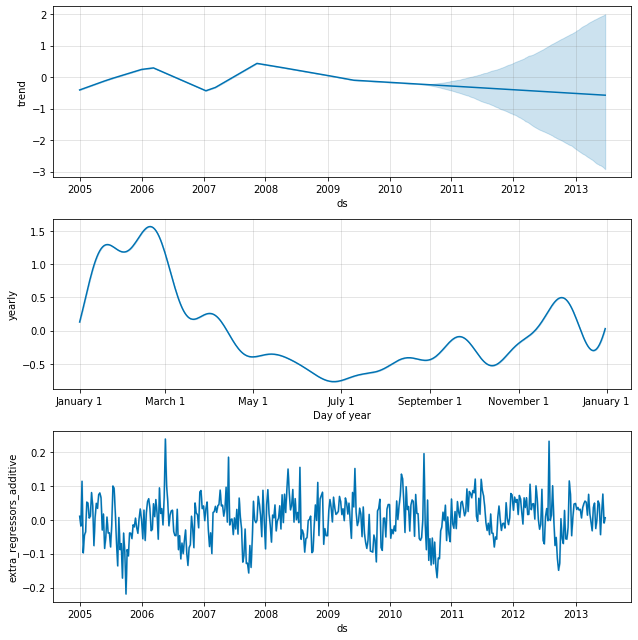

In [80]:
model.plot_components(forcast_iq_comp)

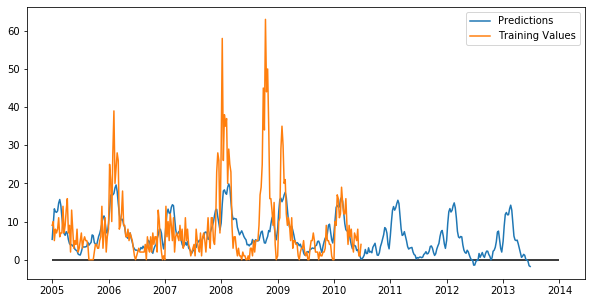

In [81]:
plt.figure(figsize=(10,5))
plt.plot(forcast_iq_comp['ds'], scale_iq.inverse_transform(forcast_iq_comp.yhat.values),label='Predictions')
plt.plot(iq.loc[iq.week_start_date.dt.year > 2004,'week_start_date'].values, iq.loc[iq.week_start_date.dt.year > 2004,'y'].values,
        label='Training Values')
plt.legend()
plt.hlines(y=0,xmin=pd.to_datetime('2005-01-01'),xmax=pd.to_datetime('2014-01-01'))
plt.show()

In [82]:
pd.set_option('display.max_rows', 500)
forcast_sj_comp['city'] ='sj'
forcast_iq_comp['city'] = 'iq'
forcast_sj_comp['yhat'] = scale_sj.inverse_transform(forcast_sj_comp.yhat.values)
forcast_iq_comp['yhat'] = scale_sj.inverse_transform(forcast_iq_comp.yhat.values)
forcast_sj_comp = forcast_sj_comp.loc[forcast_sj_comp.ds.dt.year >= 2008,:]
forcast_iq_comp = forcast_iq_comp.loc[forcast_iq_comp.ds.dt.year >= 2010,:]
display(forcast_iq_comp.loc[forcast_iq_comp.ds.dt.weekofyear == 26,:])
submission = pd.concat([pd.DataFrame(forcast_sj_comp.loc[433::,
                                                         ['ds','city','yhat']]),
                        pd.DataFrame(forcast_iq_comp.loc[286::,
                                                         ['ds','city','yhat']])])
submission['yhat'] = submission.yhat.apply(fill_0)
# submission.loc[submission.city == 'sj','yhat'] = scale_sj.inverse_transform(submission.loc[submission.city == 'sj','yhat'].values)
# submission.loc[submission.city == 'iq','yhat'] = scale_iq.inverse_transform(submission.loc[submission.city == 'iq','yhat'].values)
submission['year'] = submission.ds.dt.year
submission['weekofyear'] = submission.ds.dt.weekofyear
submission_limit = pd.DataFrame(submission.loc[submission.year > 2007,:])
submission_limit.drop(columns=['ds'], inplace=True)
submission_limit.rename(columns={'yhat':'total_cases'},inplace=True)
submission_limit = submission_limit[['city','year','weekofyear','total_cases']]
display(submission_limit.head())
submission_limit.tail()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
286 2010-07-02 -0.224230   -1.976855   -0.128653    -0.224230    -0.224230   
338 2011-07-02 -0.341476   -2.082618    0.047464    -0.775289     0.106539   
390 2012-07-01 -0.458722   -2.883424    0.339586    -1.731263     0.906827   
441 2013-06-25 -0.574041   -3.932819    1.421892    -2.925295     1.999507   

     additive_terms  additive_terms_lower  additive_terms_upper  \
286       -0.807979             -0.807979             -0.807979   
338       -0.662571             -0.662571             -0.662571   
390       -0.821539             -0.821539             -0.821539   
441       -0.760084             -0.760084             -0.760084   

     extra_regressors_additive  ...  reanalysis_tdtr_k_lower  \
286                  -0.060563  ...                -0.014075   
338                   0.086405  ...                 0.019748   
390                  -0.071052  ...                -0.062556   
441                   0.006246  ...                -0.069696   

     reanalysis_tdtr_k_upper    yearly  yearly_lower  yearly_upper  \
286                -0.014075 -0.747417     -0.747417     -0.747417   
338                 0.019748 -0.748976     -0.748976     -0.748976   
390                -0.062556 -0.750487     -0.750487     -0.750487   
441                -0.069696 -0.766331     -0.766331     -0.766331   

     multiplicative_terms  multiplicative_terms_lower  \
286                   0.0                         0.0   
338                   0.0                         0.0   
390                   0.0                         0.0   
441                   0.0                         0.0   

     multiplicative_terms_upper       yhat  city  
286                         0.0  -5.262388    iq  
338                         0.0  -4.589782    iq  
390                         0.0 -11.186718    iq  
441                         0.0 -12.473179    iq  

[4 rows x 32 columns]

city  year  weekofyear  total_cases
433   sj  2008          18            6
434   sj  2008          19            5
435   sj  2008          20            5
436   sj  2008          21            6
437   sj  2008          22            7

city  year  weekofyear  total_cases
437   iq  2013          22            0
438   iq  2013          23            0
439   iq  2013          24            0
440   iq  2013          25            0
441   iq  2013          26            0

In [83]:
len(submission_limit.total_cases.values)

416

In [84]:
submission_limit.to_csv('DengAI_submission_fbProphet.csv',index=False)